If Dockerfiles have not been modified, connect to the Jupyter server with ```http://localhost:8015/tree?token=sketchbook```.  

This notebook provides an interface to draw graphics. It is not intended as a data pipeline.  

In [1]:
import cv2
import joblib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from pyproj import Transformer
import seaborn as sns
import scipy
import sklearn
import skimage as ski

import csv
import json
import math
import os
from pathlib import Path

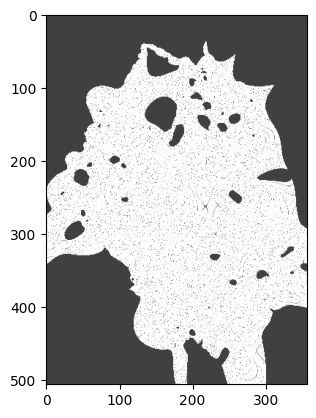

In [39]:
alpha = 0.999
top_left = (35.1327, 105.0271)
bot_right = (856.8672, 1157.4729)
resize = 0.4

def scale_df_column(df, column):
    lower = df[column].min()
    upper = df[column].max()
    d = upper - lower
    new_df = df.copy()
    new_df[f"{column}_scaled"] = new_df.apply(lambda x: (x[column] - lower) / d, axis=1)
    return new_df

def morphology_marker(i):
    markers = ['o', 'v', '^', 's', 'p', '*', 'h', 'd', 'P', 'X']
    return markers[i]

def perception_colour(i):
    colours = ["#914e72", "#3255a4", "#00a95c", "#f15060", "#765ba7", "#407060", "#bb8b41", "#ffe800", "#ff48b0"]
    return colours[i]

image = cv2.imread("data/Grid for warping.png")
width = abs(bot_right[0] - top_left[0])
height = abs(bot_right[1] - top_left[1])
image_height, image_width, _ = np.array(image).shape
transformer = Transformer.from_crs(4326, 3414, always_xy=True)
geographical_pos = {}
with open("data/thomson-id.csv", 'r') as fp:
    reader = csv.reader(fp)
    next(reader)
    for row in reader:
        geographical_pos[row[0]] = transformer.transform(row[2], row[1])
geographical_df = pd.DataFrame.from_dict(geographical_pos, orient="index", columns=["x", "y"])
geographical_df = scale_df_column(scale_df_column(geographical_df, "x"), "y")
with open("data/thomson-perceptions-clustering/clustering-perceptions.csv", 'r') as fp:
    morphology_df = pd.read_csv(fp, index_col=0)
morphology_df = scale_df_column(scale_df_column(morphology_df, "x"), "y")
with open("data/thomson-segmented-point-clouds-combined-encoded-clustering/clustering-segmented-point-clouds-combined-encoded.csv", 'r') as fp:
    perception_df = pd.read_csv(fp, index_col=0)
perception_df = scale_df_column(scale_df_column(perception_df, "x"), "y")
# cluster_df = morphology_df.join(perception_df, how="inner", lsuffix="_morphology", rsuffix="_perception")
map_df = morphology_df.join(perception_df, how="inner", lsuffix="_morphology", rsuffix="_perception")
map_df = geographical_df.join(map_df, how="inner")
map_df["morphology_marker"] = map_df.apply(lambda df: morphology_marker(int(df["cluster_morphology"])), axis=1)
map_df["perception_colour"] = map_df.apply(lambda df: perception_colour(int(df["cluster_perception"])), axis=1)

map_df["x_source"] = (map_df["x_scaled_morphology"] + map_df["x_scaled_perception"]) / 2
map_df["y_source"] = (map_df["y_scaled_morphology"] + map_df["y_scaled_perception"]) / 2
map_df["x_target"] = map_df.apply(lambda df: (1 - alpha) * df["x_source"] + (alpha) * df["x_scaled"], axis=1)
map_df["y_target"] = map_df.apply(lambda df: (1 - alpha) * df["y_source"] + (alpha) * df["y_scaled"], axis=1)
# map_df["x_target"] = map_df.apply(lambda df: (alpha * (df["x_scaled_morphology"]) + (1 - alpha) * df["x_scaled"]), axis=1)
# map_df["y_target"] = map_df.apply(lambda df: (alpha * (df["y_scaled_morphology"]) + (1 - alpha) * df["y_scaled"]), axis=1)
# map_df["x_target"] = map_df.apply(lambda df: (alpha * (df["x_scaled_perception"]) + (1 - alpha) * df["x_scaled"]), axis=1)
# map_df["y_target"] = map_df.apply(lambda df: (alpha * (df["y_scaled_perception"]) + (1 - alpha) * df["y_scaled"]), axis=1)

image = cv2.resize(image, (round(image_width * resize), round(image_height * resize)))
map_df["x_image_source"] = (map_df["x_source"] * width + top_left[0]) * resize
map_df["y_image_source"] = ((1 - map_df["y_source"]) * height + top_left[1]) * resize
map_df["x_image_target"] = (map_df["x_target"] * width + top_left[0]) * resize
map_df["y_image_target"] = ((1 - map_df["y_target"]) * height + top_left[1]) * resize
# map_df = map_df.drop(map_df[map_df.cluster_morphology != 9].index)
# map_df = map_df.drop(map_df[map_df.cluster_perception != 8].index)

source = map_df[["x_image_source", "y_image_source"]].to_numpy()
target = map_df[["x_image_target", "y_image_target"]].to_numpy()

src = source
dst = target

# Estimate the TPS transformation from these points and then warp the image.
# We switch `src` and `dst` here because `skimage.transform.warp` requires the
# inverse transformation!
tps = ski.transform.ThinPlateSplineTransform()
tps.estimate(dst, src)
warped = ski.transform.warp(image, tps, order=0)

# # Plot the results
fig, axs = plt.subplots()

# axs = sns.scatterplot(data=map_df, x="x_image_source", y="y_image_source", s=150,
#                 style="cluster_morphology", markers={0: 'o', 1:'v', 2: '^', 3: 's', 4: 'p', 5: '*', 6: 'h', 7: 'd', 8: 'P', 9: 'X'},
#                 hue="cluster_perception", palette={0: "#914e72", 1: "#3255a4", 2: "#00a95c", 3: "#f15060", 4: "#765ba7", 5: "#407060", 6: "#bb8b41", 7: "#ffe800", 8: "#ff48b0"})
# sns.move_legend(axs, "lower left", bbox_to_anchor=(1, 0), fontsize=15, labels=["Perception cluster", 1,2,3,4,5,6,7,8,9, "Morphology Cluster", 1,2,3,4,5,6,7,8,9,10])
# axs.set_aspect("equal")
# axs.get_xaxis().set_visible(False)
# axs.get_yaxis().set_visible(False)
# axs.imshow(image, alpha=0.75)

# axs = sns.scatterplot(data=map_df, x="x_image_target", y="y_image_target",
#                 style="cluster_morphology", markers={0: 'o', 1:'v', 2: '^', 3: 's', 4: 'p', 5: '*', 6: 'h', 7: 'd', 8: 'P', 9: 'X'},
#                 hue="cluster_perception", palette={0: "#914e72", 1: "#3255a4", 2: "#00a95c", 3: "#f15060", 4: "#765ba7", 5: "#407060", 6: "#bb8b41", 7: "#ffe800", 8: "#ff48b0"})
# sns.move_legend(axs, "lower left", bbox_to_anchor=(1, 0), labels=["Perception cluster", 1,2,3,4,5,6,7,8, "Morphology Cluster", 1,2,3,4,5,6,7,8,9])
axs.set_aspect("equal")
# axs.get_xaxis().set_visible(False)
# axs.get_yaxis().set_visible(False)
axs.imshow(warped, alpha=0.75)

# axs = sns.scatterplot(data=map_df, x="x_image_target", y="y_image_target", s=150, color="black",
#                 style="cluster_morphology", markers={0: 'o', 1:'v', 2: '^', 3: 's', 4: 'p', 5: '*', 6: 'h', 7: 'd', 8: 'P', 9: 'X'})
# sns.move_legend(axs, "lower left", bbox_to_anchor=(1, 0), fontsize=15)
# axs.set_aspect("equal")
# axs.get_xaxis().set_visible(False)
# axs.get_yaxis().set_visible(False)
# axs.set_ylim(axs.get_ylim()[::-1])

# axs = sns.scatterplot(data=map_df, x="x_image_target", y="y_image_target", s=150, style='x',
#                 hue="cluster_perception", palette={0: "#914e72", 1: "#3255a4", 2: "#00a95c", 3: "#f15060", 4: "#765ba7", 5: "#407060", 6: "#bb8b41", 7: "#ffe800", 8: "#ff48b0"})
# plt.legend([], [], frameon=False)
# axs.set_aspect("equal")
# axs.get_xaxis().set_visible(False)
# axs.get_yaxis().set_visible(False)
# axs.set_ylim(axs.get_ylim()[::-1])

# Path("data/thomson grid warped").mkdir(parents=True, exist_ok=True)
with open(os.path.join("data", f"thomson grid warped.png"), 'wb') as fp:
    plt.savefig(fp, transparent=True, bbox_inches="tight", pad_inches=0)
# Image.fromarray(warped).save(os.path.join(f"data/shunfu-warped/perception_8_{alpha}.png"))

In [ ]:
alpha = 1
top_left = (615, 1663)
bot_right = (13416, 18204)
image_width, image_height = (14031, 19866)
resize = 1
resolution = 177 # in number of pixels per colour

def scale_df_column(df, column):
    lower = df[column].min()
    upper = df[column].max()
    d = upper - lower
    new_df = df.copy()
    new_df[f"{column}_scaled"] = new_df.apply(lambda x: (x[column] - lower) / d, axis=1)
    return new_df

width = abs(bot_right[0] - top_left[0])
height = abs(bot_right[1] - top_left[1])
transformer = Transformer.from_crs(4326, 3414, always_xy=True)
geographical_pos = {}
with open("data/thomson-id.csv", 'r') as fp:
    reader = csv.reader(fp)
    next(reader)
    for row in reader:
        geographical_pos[row[0]] = transformer.transform(row[2], row[1])
geographical_df = pd.DataFrame.from_dict(geographical_pos, orient="index", columns=["x", "y"])
geographical_df = scale_df_column(scale_df_column(geographical_df, "x"), "y")
with open("data/thomson-perceptions-clustering/clustering-perceptions.csv", 'r') as fp:
    morphology_df = pd.read_csv(fp, index_col=0)
morphology_df = scale_df_column(scale_df_column(morphology_df, "x"), "y")
with open("data/thomson-segmented-point-clouds-combined-encoded-clustering/clustering-segmented-point-clouds-combined-encoded.csv", 'r') as fp:
    perception_df = pd.read_csv(fp, index_col=0)
perception_df = scale_df_column(scale_df_column(perception_df, "x"), "y")
map_df = morphology_df.join(perception_df, how="inner", lsuffix="_morphology", rsuffix="_perception")
map_df = geographical_df.join(map_df, how="inner")

map_df["x_source"] = map_df["x_scaled"]
map_df["y_source"] = map_df["y_scaled"]
map_df["x_target"] = map_df.apply(lambda df: (1 - alpha) * df["x_source"] + (alpha) * ((df["x_scaled_morphology"] + df["x_scaled_perception"]) / 2), axis=1)
map_df["y_target"] = map_df.apply(lambda df: (1 - alpha) * df["y_source"] + (alpha) * ((df["y_scaled_morphology"] + df["y_scaled_perception"]) / 2), axis=1)

map_df["x_image_source"] = (map_df["x_source"] * width + top_left[0]) * resize
map_df["y_image_source"] = ((1 - map_df["y_source"]) * height + top_left[1]) * resize
map_df["x_image_target"] = (map_df["x_target"] * width + top_left[0]) * resize
map_df["y_image_target"] = ((1 - map_df["y_target"]) * height + top_left[1]) * resize

source = map_df[["x_image_source", "y_image_source"]].to_numpy()
target = map_df[["x_image_target", "y_image_target"]].to_numpy()

vectors = target - source
u = vectors[:, 0]
v = vectors[:, 1]

xx = np.linspace(0, image_width, int(image_width / resolution))
yy = np.linspace(0, image_height, int(image_height / resolution))
xx, yy = np.meshgrid(xx, yy)

u_interp = scipy.interpolate.griddata(source, u, (xx, yy), method="cubic", fill_value=0)
v_interp = scipy.interpolate.griddata(source, v, (xx, yy), method="cubic", fill_value=0)

angle = np.atan2(v_interp, u_interp)
angle[angle < 0] += 2 * np.pi
magnitude = np.sqrt(u_interp**2, v_interp**2)

# hue = angle / (2 * np.pi)
# value = (magnitude / magnitude.max())
# saturation = np.ones_like(hue)
# hsv = np.stack((hue, saturation, value), axis=-1)
# rgb = mcolors.hsv_to_rgb(hsv)

# fig, ax = plt.subplots(figsize=(image_width / 300, image_height / 300))
# ax.axis("off")
# ax = plt.imshow(value, cmap="Greys")
# with open("data/test colour map magnitude.png", 'wb') as fp:
#     plt.savefig(fp, bbox_inches="tight")

In [5]:
with open("data/thomson vector field.json", 'w') as fp:
    json.dump(angle.tolist(), fp)

In [ ]:
target_dir = "data"
input_dir = "shunfu-perceptions"

datas_path = []
for dirpath, dirnames, filenames in os.walk(os.path.join(target_dir, input_dir)):
    datas_path.extend(filenames)
    break
datas_id = {}
for data_path in datas_path:
    with open(os.path.join(target_dir, input_dir, data_path), 'r') as fp:
        datas_id['.'.join(data_path.split('.')[:-1])] = json.load(fp)
datas_df = pd.DataFrame.from_dict(datas_id, orient='index')
datas_df.index.name = "id"

with open("data/shunfu-id.csv", 'r') as fp:
    locations = pd.read_csv(fp, index_col=0)
locations = locations.drop_duplicates()
perceptions = datas_df.join(locations[["lat", "lon"]], how="inner")
perceptions.to_csv("data/perceptions.csv")

In [ ]:
target_dir = "data"
input_dir = "thomson-segmented-point-clouds-combined-encoded"
models_dir = "thomson-segmented-point-clouds-combined-encoded-clustering"
cluster_no = 8

datas_path = []
for dirpath, dirnames, filenames in os.walk(os.path.join(target_dir, input_dir)):
    datas_path.extend(filenames)
    break
datas_id = {}
for data_path in datas_path:
    with open(os.path.join(target_dir, input_dir, data_path), 'r') as fp:
        datas_id['.'.join(data_path.split('.')[:-1])] = json.load(fp)
datas_df = pd.DataFrame.from_dict(datas_id, orient='index')

with open(os.path.join(target_dir, models_dir, "scaler-segmented-point-clouds-combined-encoded.pkl"), "rb") as fp:
    scaler = joblib.load(fp)
with open(os.path.join(target_dir, models_dir, "pca-segmented-point-clouds-combined-encoded.pkl"), "rb") as fp:
    pca = joblib.load(fp)
with open(os.path.join(target_dir, models_dir, "kmeans-segmented-point-clouds-combined-encoded.pkl"), "rb") as fp:
    kmeans = joblib.load(fp)
with open(os.path.join(target_dir, models_dir, "clustering-segmented-point-clouds-combined-encoded.csv"), 'r') as fp:
    point_clouds_df = pd.read_csv(fp, index_col=0)

cluster_df = datas_df.loc[datas_df.index.isin(point_clouds_df.loc[point_clouds_df["cluster"] == cluster_no].index)]
print(cluster_df)
dist_to_centre = np.linalg.norm(kmeans.transform(pca.transform(scaler.transform(cluster_df.values))) - kmeans.transform(kmeans.cluster_centers_[cluster_no].reshape(1, pca.components_.shape[0])), axis=1)
cluster_with_dist_df = pd.DataFrame(dist_to_centre, index=cluster_df.index, columns=["dist_to_centre"]).sort_values(by="dist_to_centre", ascending=True)
top_8 = cluster_with_dist_df.head(8).index
print(top_8)

In [ ]:
target_dir = "data"
morphology_dir = "thomson-segmented-point-clouds-combined-encoded"
morphology_models_dir = "thomson-segmented-point-clouds-combined-encoded-clustering"
morphology_cluster = 8
perception_dir = "thomson-perceptions"
perception_models_dir = "thomson-perceptions-clustering"
perception_cluster = 7

morphologys_path = []
for dirpath, dirnames, filenames in os.walk(os.path.join(target_dir, morphology_dir)):
    morphologys_path.extend(filenames)
    break
morphologys_id = {}
for morphology_path in morphologys_path:
    with open(os.path.join(target_dir, morphology_dir, morphology_path), 'r') as fp:
        morphologys_id['.'.join(morphology_path.split('.')[:-1])] = json.load(fp)
morphologys_df = pd.DataFrame.from_dict(morphologys_id, orient='index')

with open(os.path.join(target_dir, morphology_models_dir, "scaler-segmented-point-clouds-combined-encoded.pkl"), "rb") as fp:
    morphology_scaler = joblib.load(fp)
with open(os.path.join(target_dir, morphology_models_dir, "pca-segmented-point-clouds-combined-encoded.pkl"), "rb") as fp:
    morphology_pca = joblib.load(fp)
with open(os.path.join(target_dir, morphology_models_dir, "kmeans-segmented-point-clouds-combined-encoded.pkl"), "rb") as fp:
    morphology_kmeans = joblib.load(fp)
with open(os.path.join(target_dir, morphology_models_dir, "clustering-segmented-point-clouds-combined-encoded.csv"), 'r') as fp:
    morphology_clusters_df = pd.read_csv(fp, index_col=0)
morphology_clusters_df["norm_dist_to_centre"] = morphology_clusters_df.apply(lambda row: np.linalg.norm(morphology_kmeans.transform(morphology_pca.transform(morphology_scaler.transform(morphologys_df.loc[row.name].values.reshape(1, -1))))
                                                                                                        - morphology_kmeans.transform(morphology_kmeans.cluster_centers_[int(row["cluster"])].reshape(1, -1))), axis=1)
morphology_clusters_df["norm_dist_to_centre"] /= morphology_clusters_df["norm_dist_to_centre"].max()

perceptions_path = []
for dirpath, dirnames, filenames in os.walk(os.path.join(target_dir, perception_dir)):
    perceptions_path.extend(filenames)
    break
perceptions_id = {}
for perception_path in perceptions_path:
    with open(os.path.join(target_dir, perception_dir, perception_path), 'r') as fp:
        perceptions_id['.'.join(perception_path.split('.')[:-1])] = json.load(fp)
perceptions_df = pd.DataFrame.from_dict(perceptions_id, orient='index')

with open(os.path.join(target_dir, perception_models_dir, "kmeans-perceptions.pkl"), "rb") as fp:
    perception_kmeans = joblib.load(fp)
with open(os.path.join(target_dir, perception_models_dir, "clustering-perceptions.csv"), 'r') as fp:
    perception_clusters_df = pd.read_csv(fp, index_col=0)
perception_clusters_df["norm_dist_to_centre"] = perception_clusters_df.apply(lambda row: np.linalg.norm(perception_kmeans.transform(perceptions_df.loc[row.name].values.reshape(1, -1))
                                                                                                        - perception_kmeans.transform(perception_kmeans.cluster_centers_[int(row["cluster"])].reshape(1, -1))), axis=1)
perception_clusters_df["norm_dist_to_centre"] /= perception_clusters_df["norm_dist_to_centre"].max()

clusters_df = morphology_clusters_df[["cluster", "norm_dist_to_centre"]].join(perception_clusters_df[["cluster", "norm_dist_to_centre"]], how="inner", lsuffix="_morphology", rsuffix="_perception")
clusters_df["mean_cluster_dist"] = (clusters_df["norm_dist_to_centre_morphology"] + clusters_df["norm_dist_to_centre_perception"]) / 2
filtered_clusters_df = clusters_df.loc[(clusters_df["cluster_morphology"] == morphology_cluster) & (clusters_df["cluster_perception"] == perception_cluster)].sort_values(by="mean_cluster_dist", ascending=True)
top_8 = filtered_clusters_df.head(8).index
print(top_8)

0 0
(26.7194678917262, 27.528273582423278, 23.92855934548252, 23.508073109586412, 26.950501060191947, 27.434880639872755, 26.7194678917262)
1 1
(26.004583230060522, 26.59755007443715, 24.569019181232203, 24.16043357273655, 26.538565030820468, 27.047671437063546, 26.004583230060522)
2 2
(25.137914731057123, 24.6022813331334, 24.71120015701138, 24.78538413472674, 25.531805560813726, 25.91167811373115, 25.137914731057123)
3 3
(26.85161139736107, 26.904828289455768, 24.229124415917646, 23.980470434447586, 27.09391881127423, 27.453464603610787, 26.85161139736107)
4 4
(26.053719182824807, 27.12366984085127, 24.201354516701727, 23.715089092210388, 26.598144935783413, 27.62387045037359, 26.053719182824807)
5 5
(26.974671841504307, 26.30527939423966, 24.505106417169202, 24.064167360155118, 26.911882004344914, 26.504187065152543, 26.974671841504307)
6 6
(26.12412339189362, 25.294094713440607, 24.582166326607144, 24.604768670000055, 26.441936735546644, 26.316351102643925, 26.12412339189362)
7 7
(

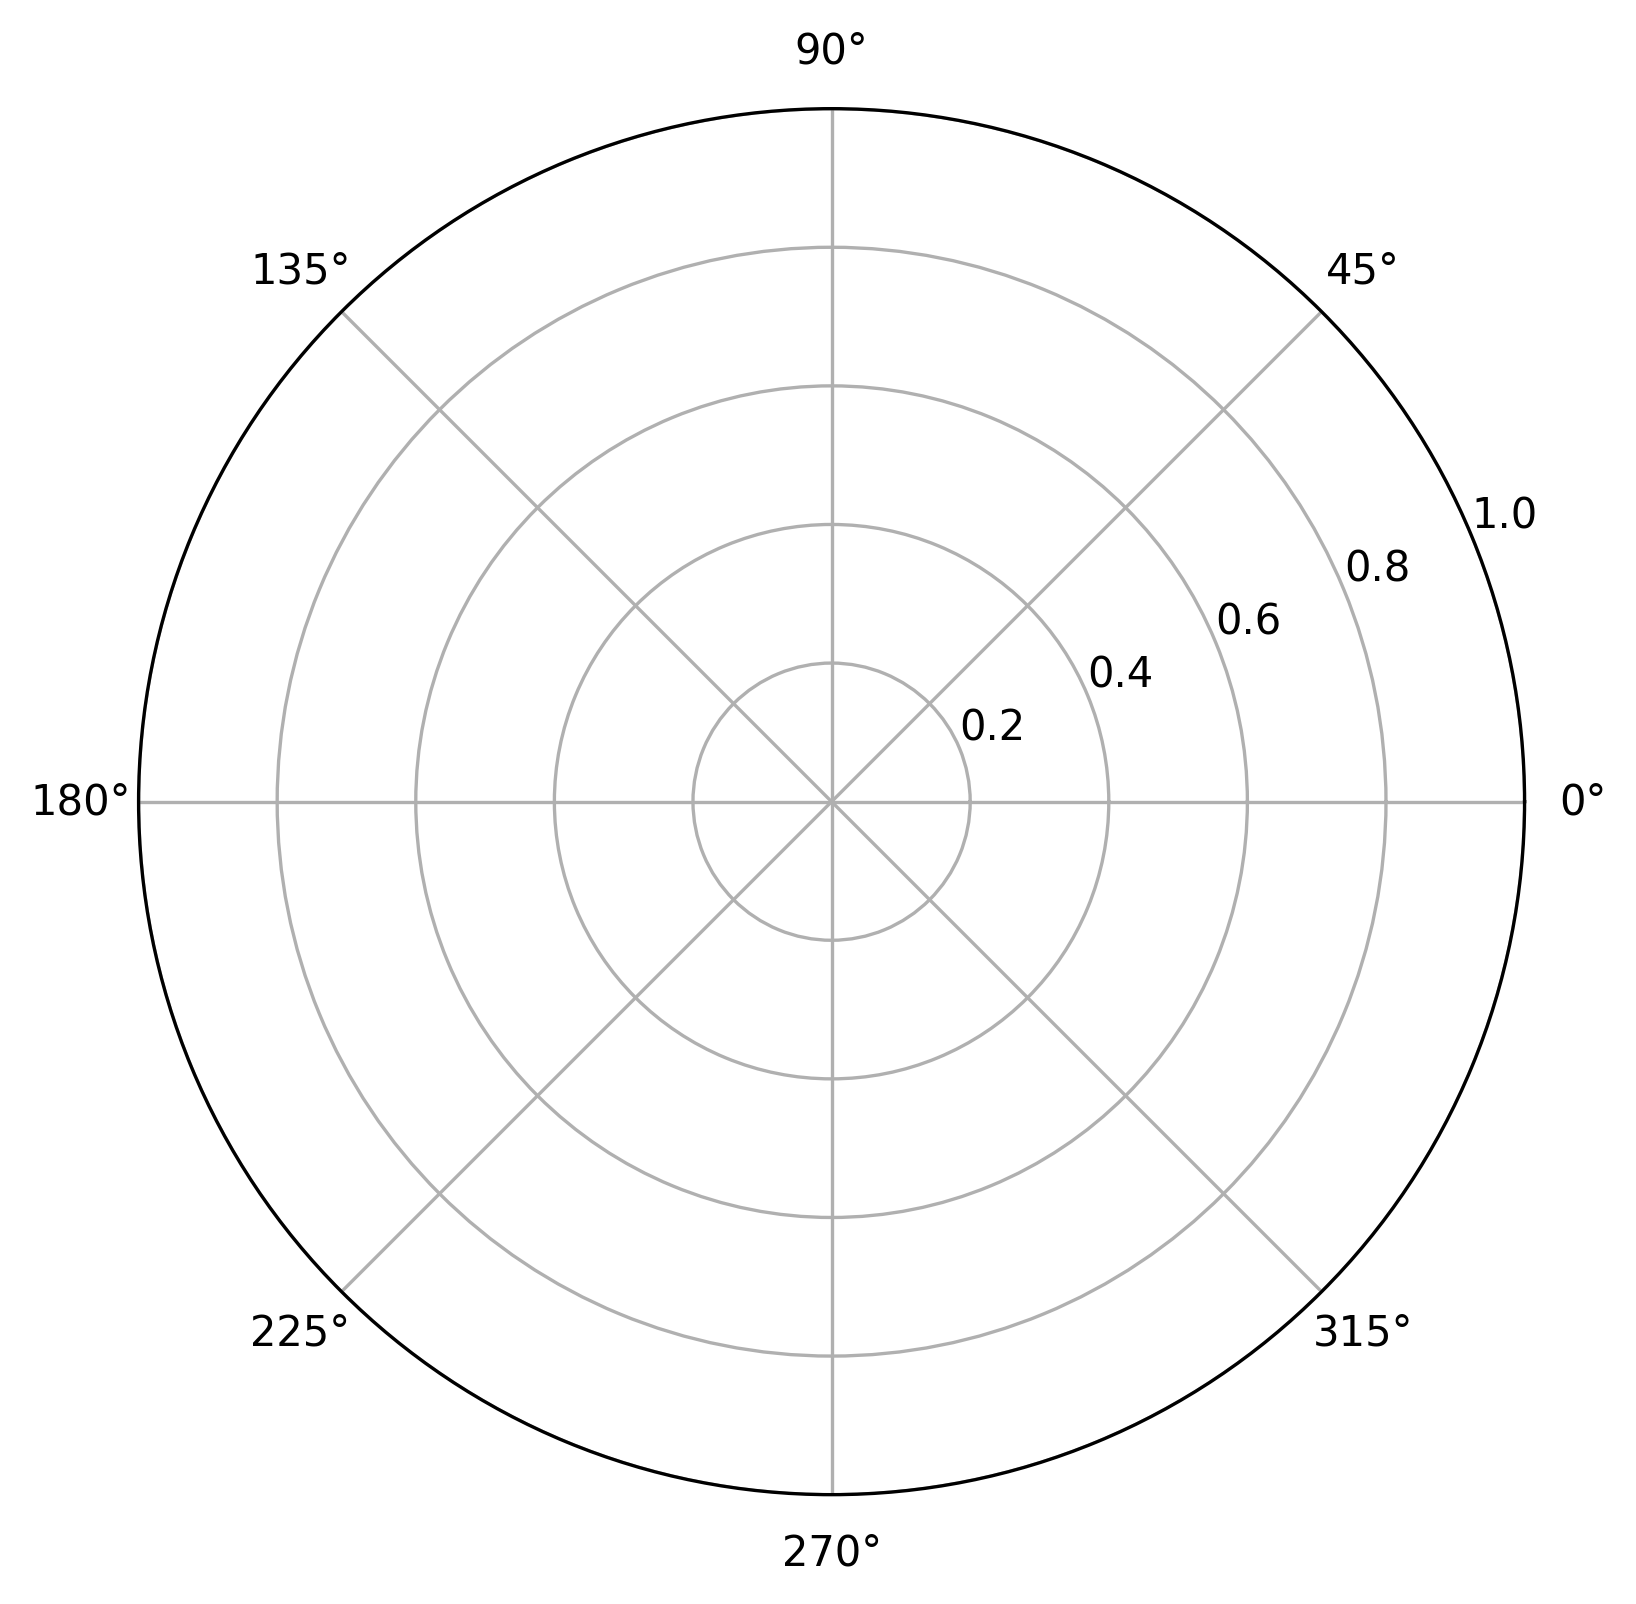

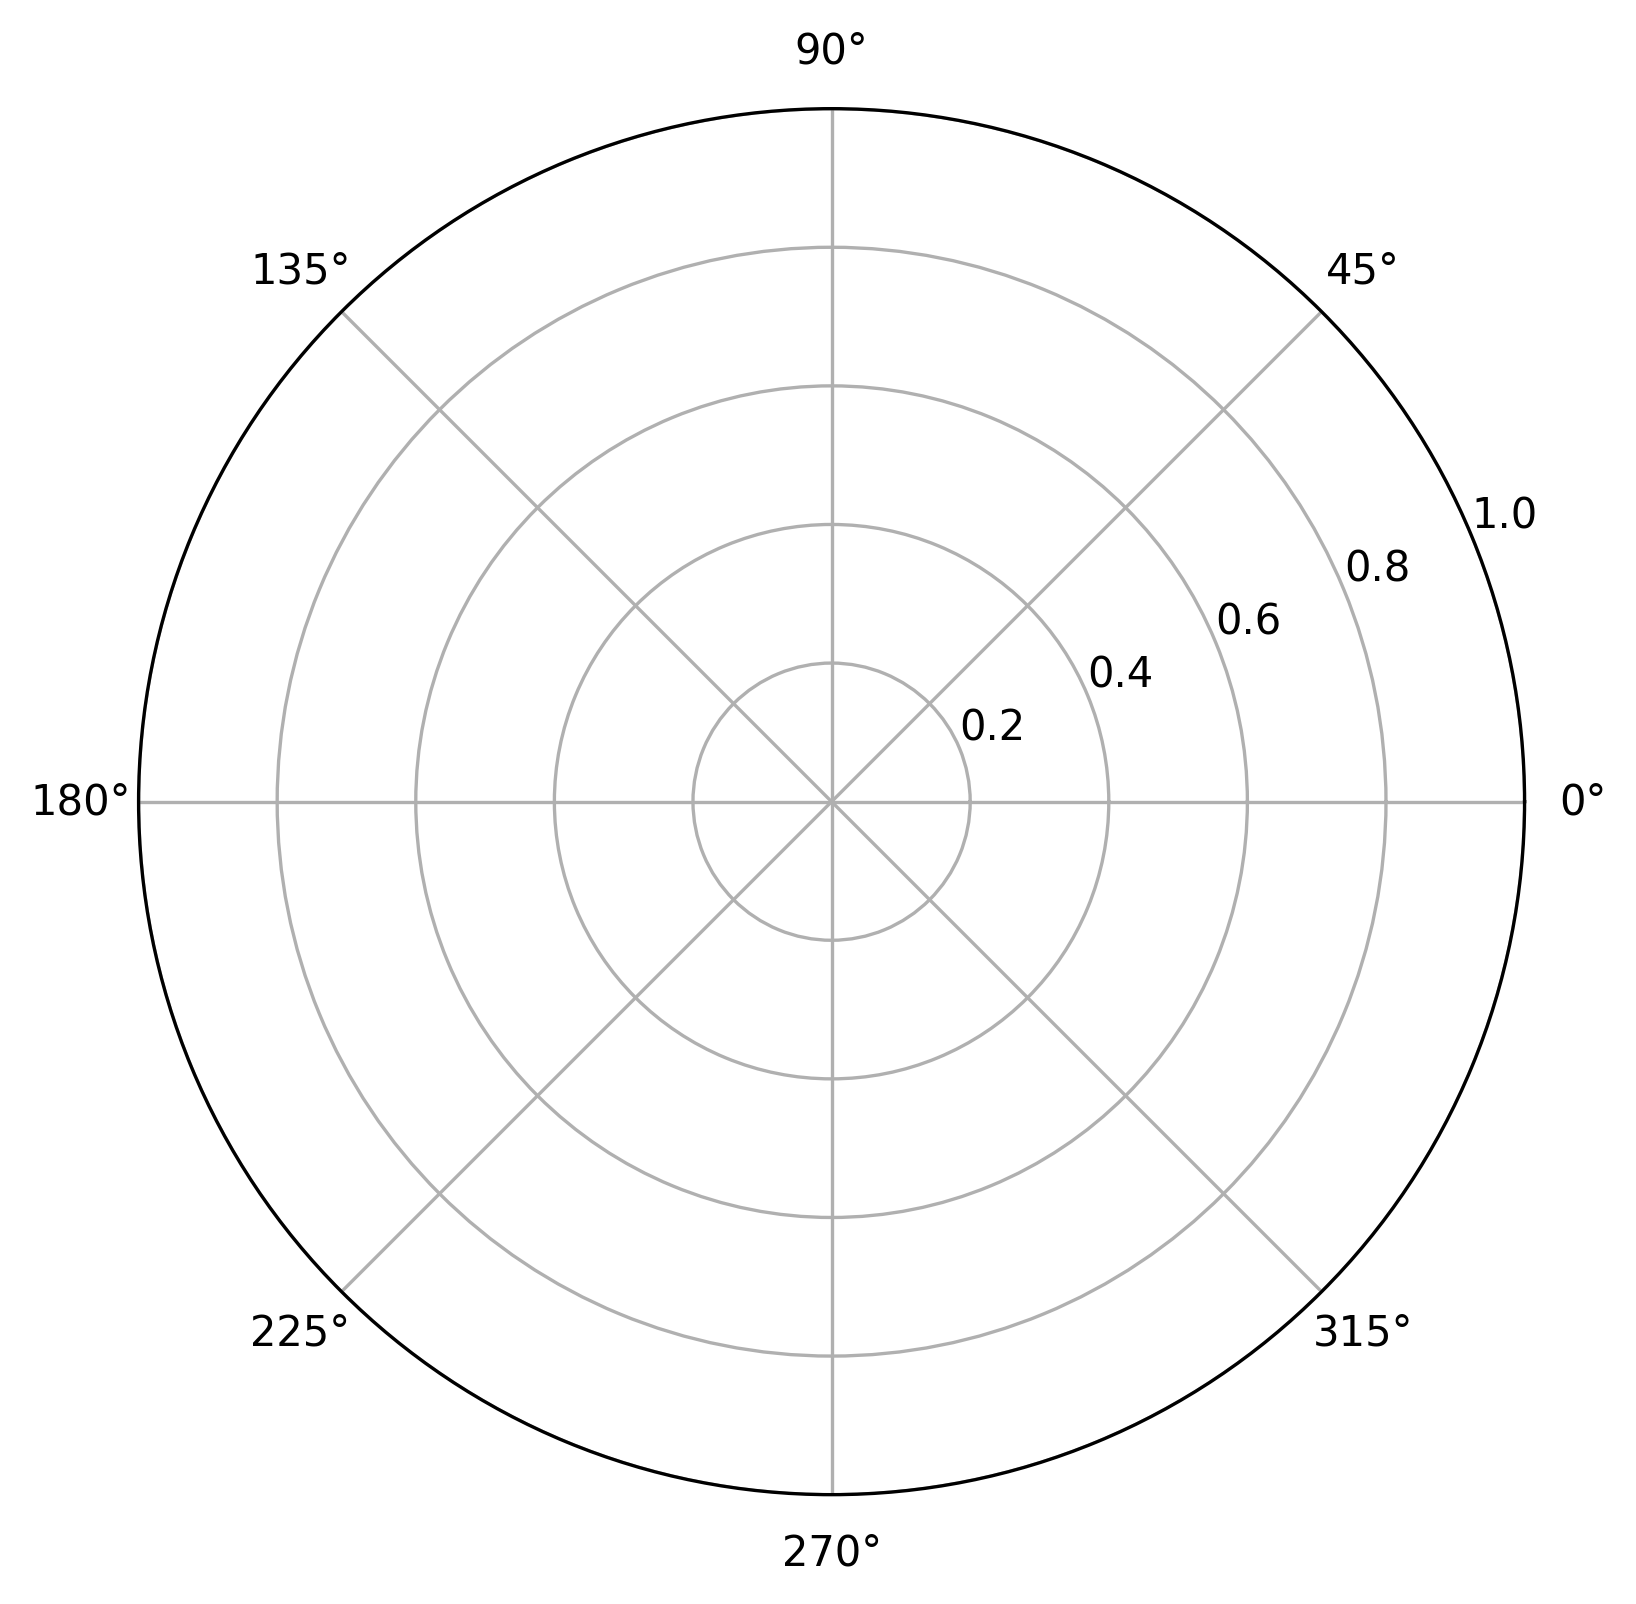

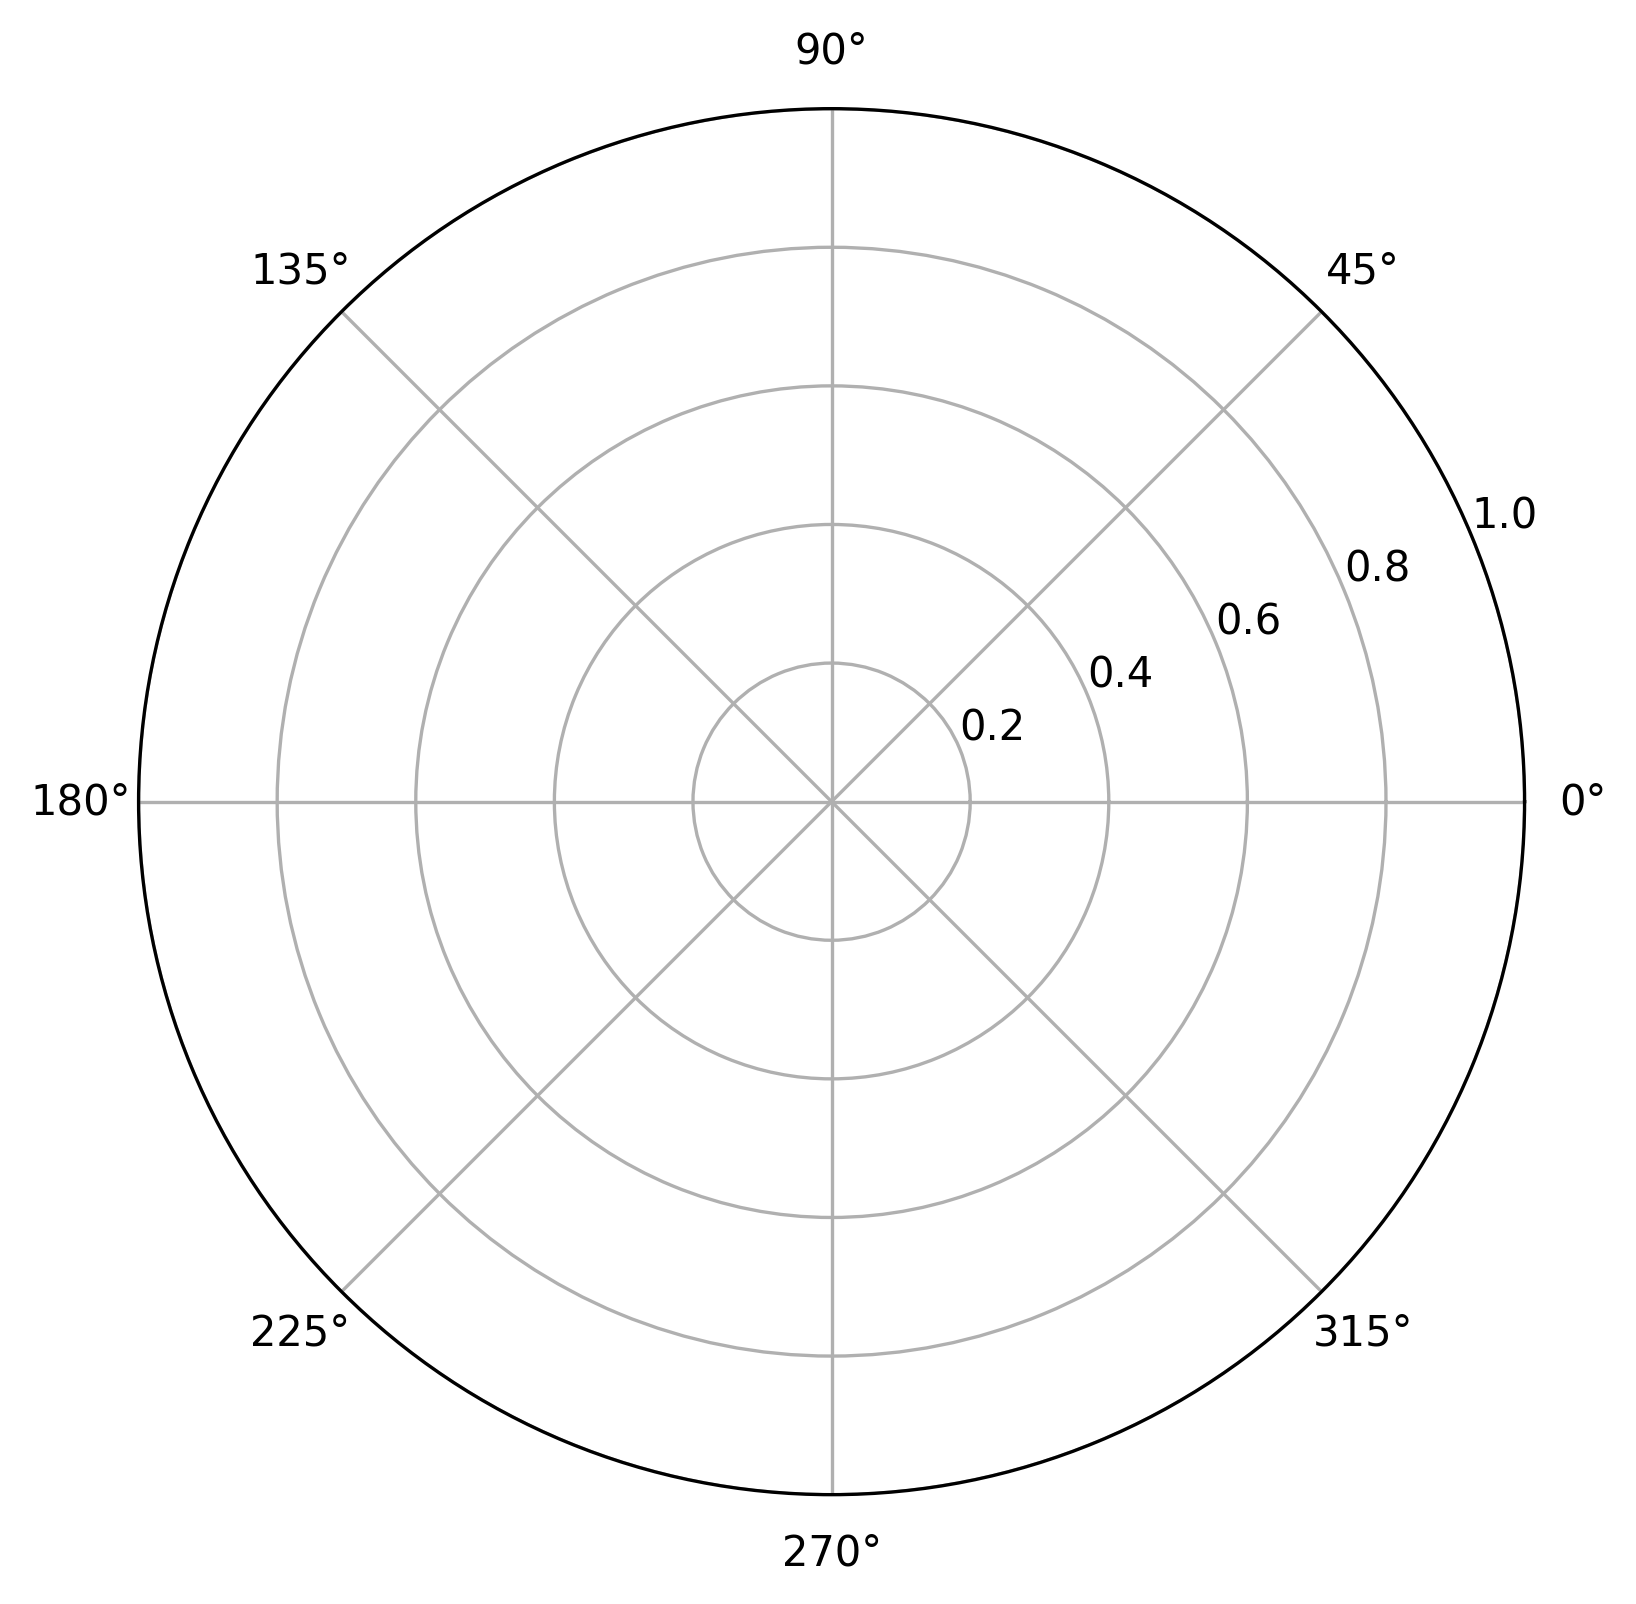

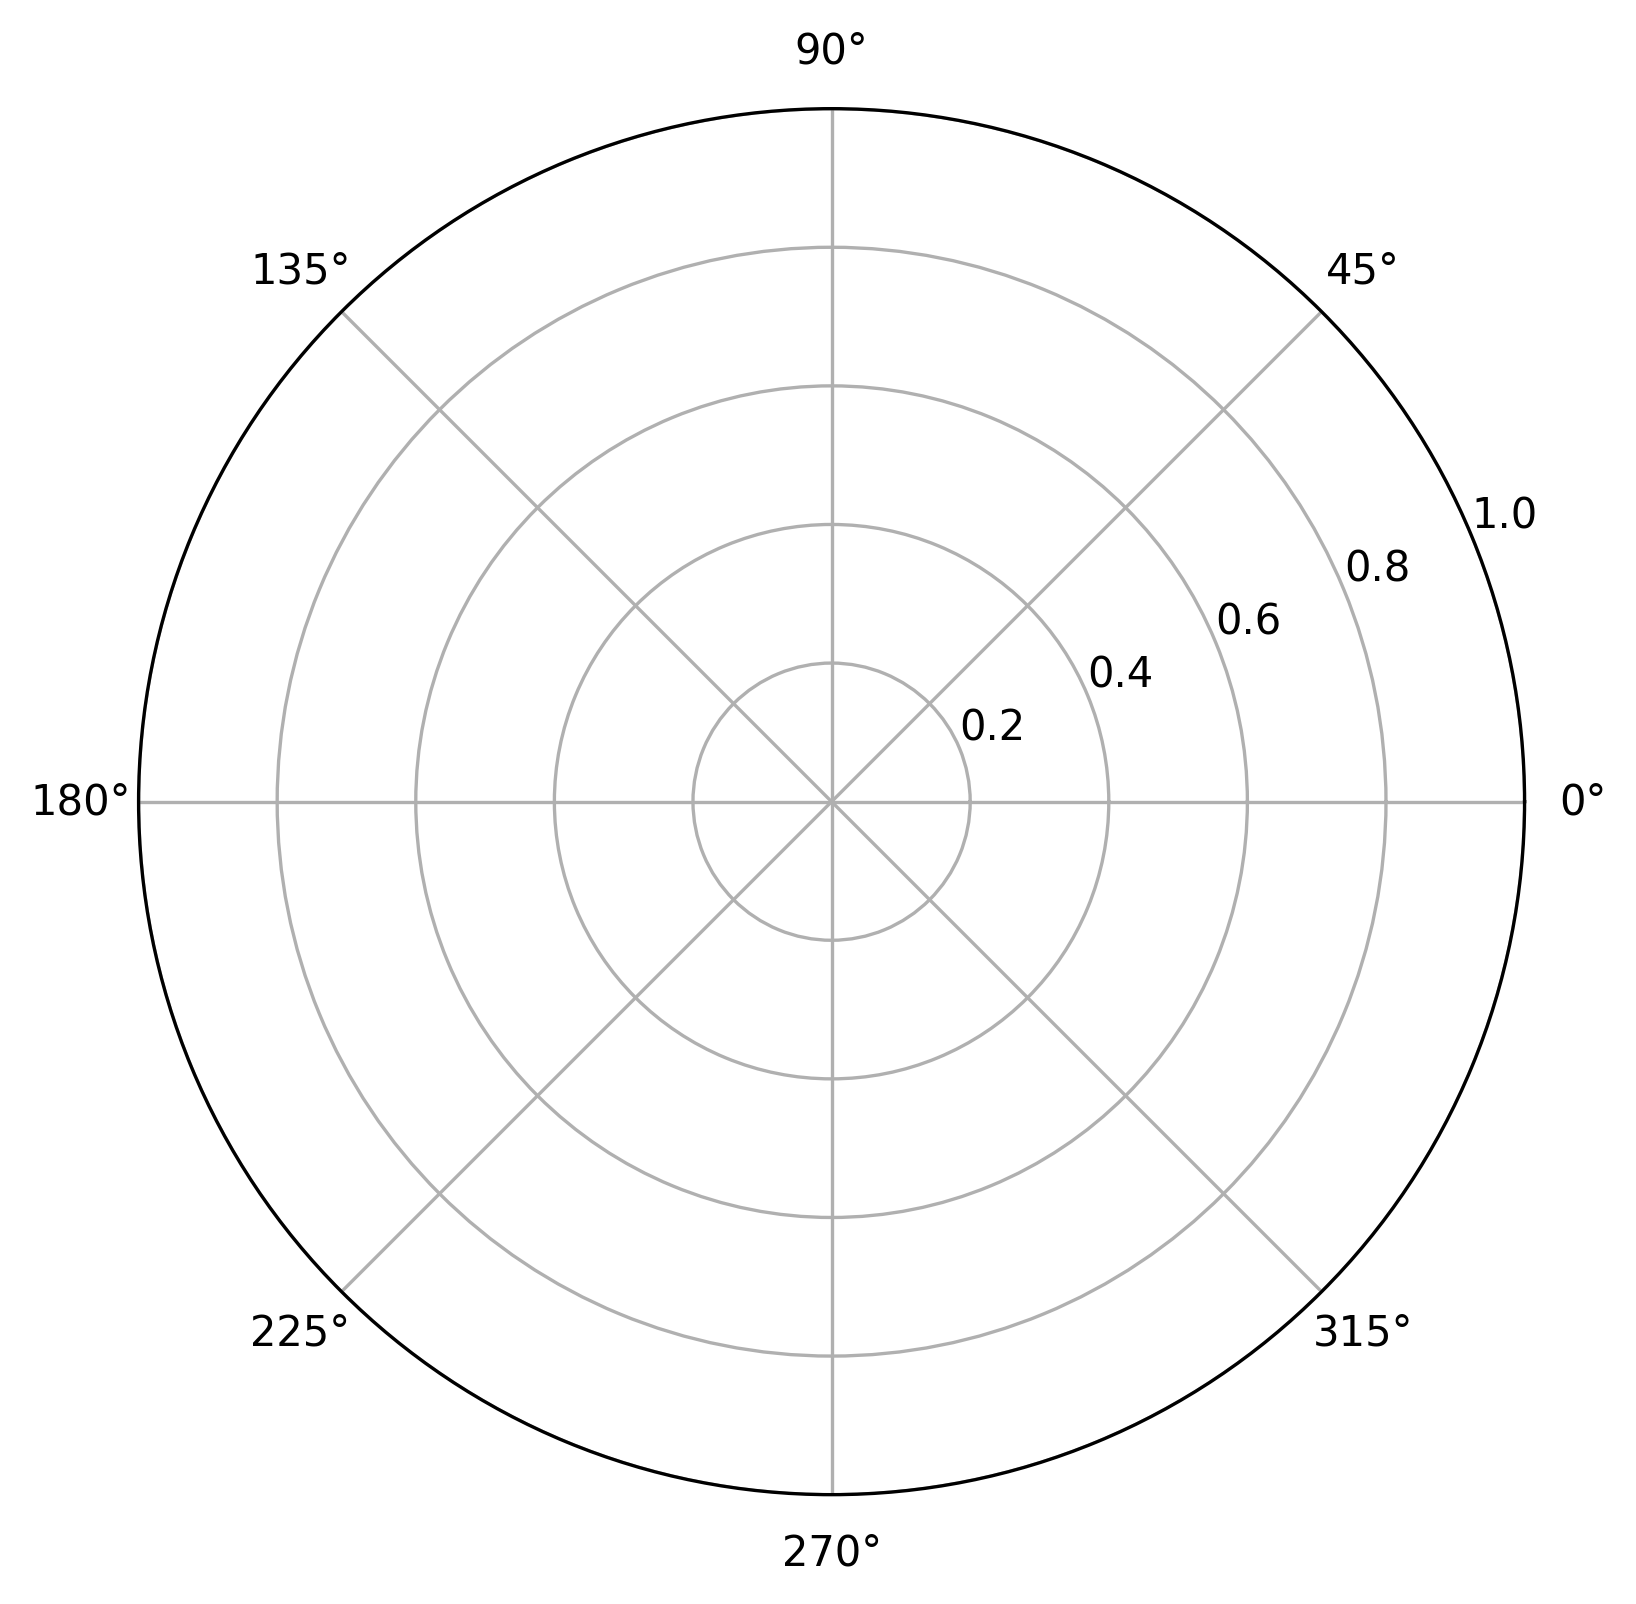

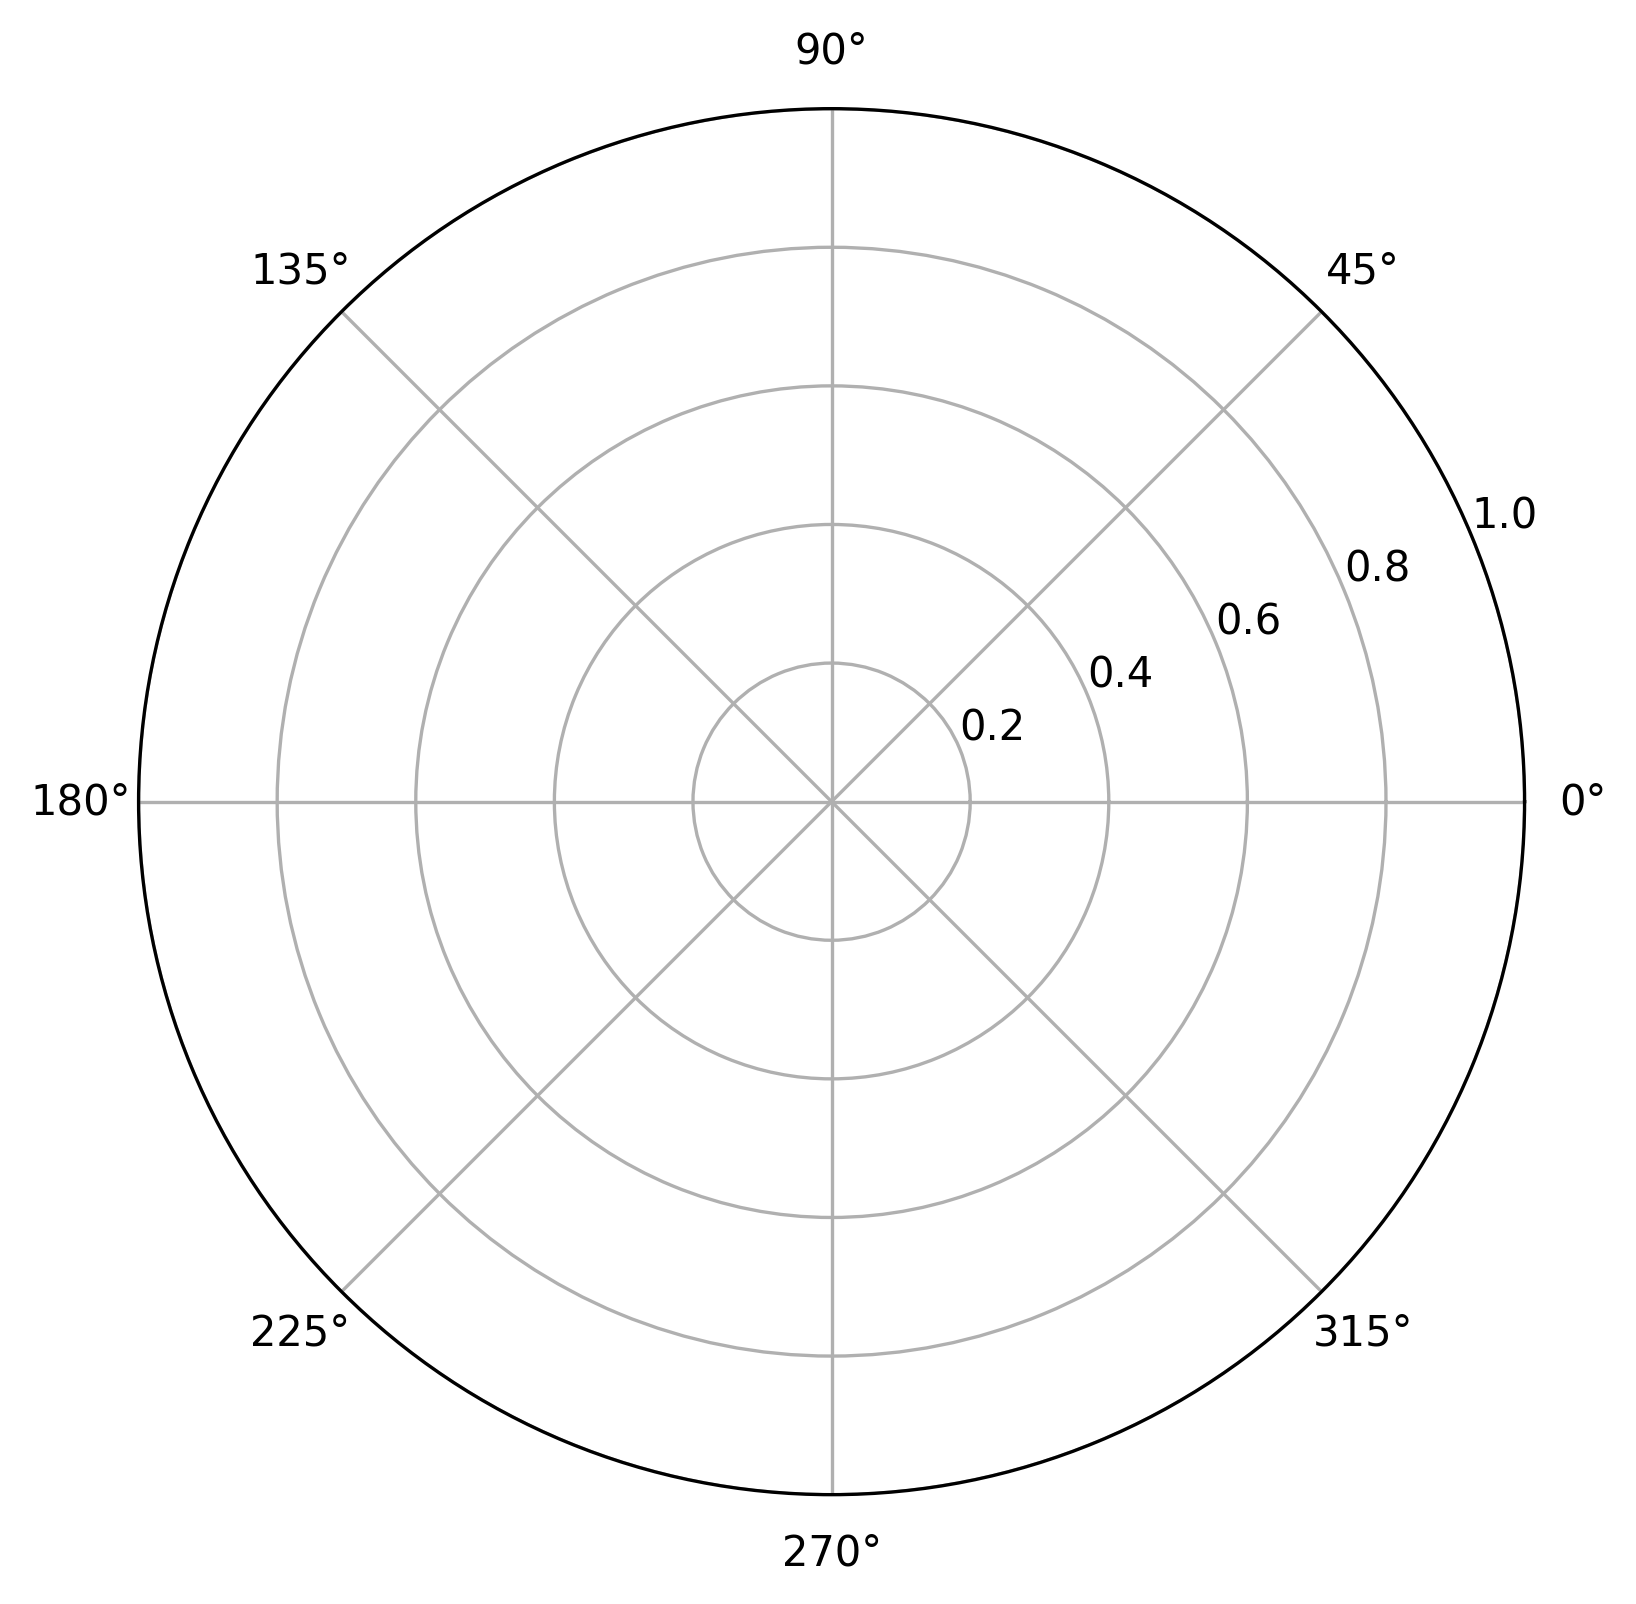

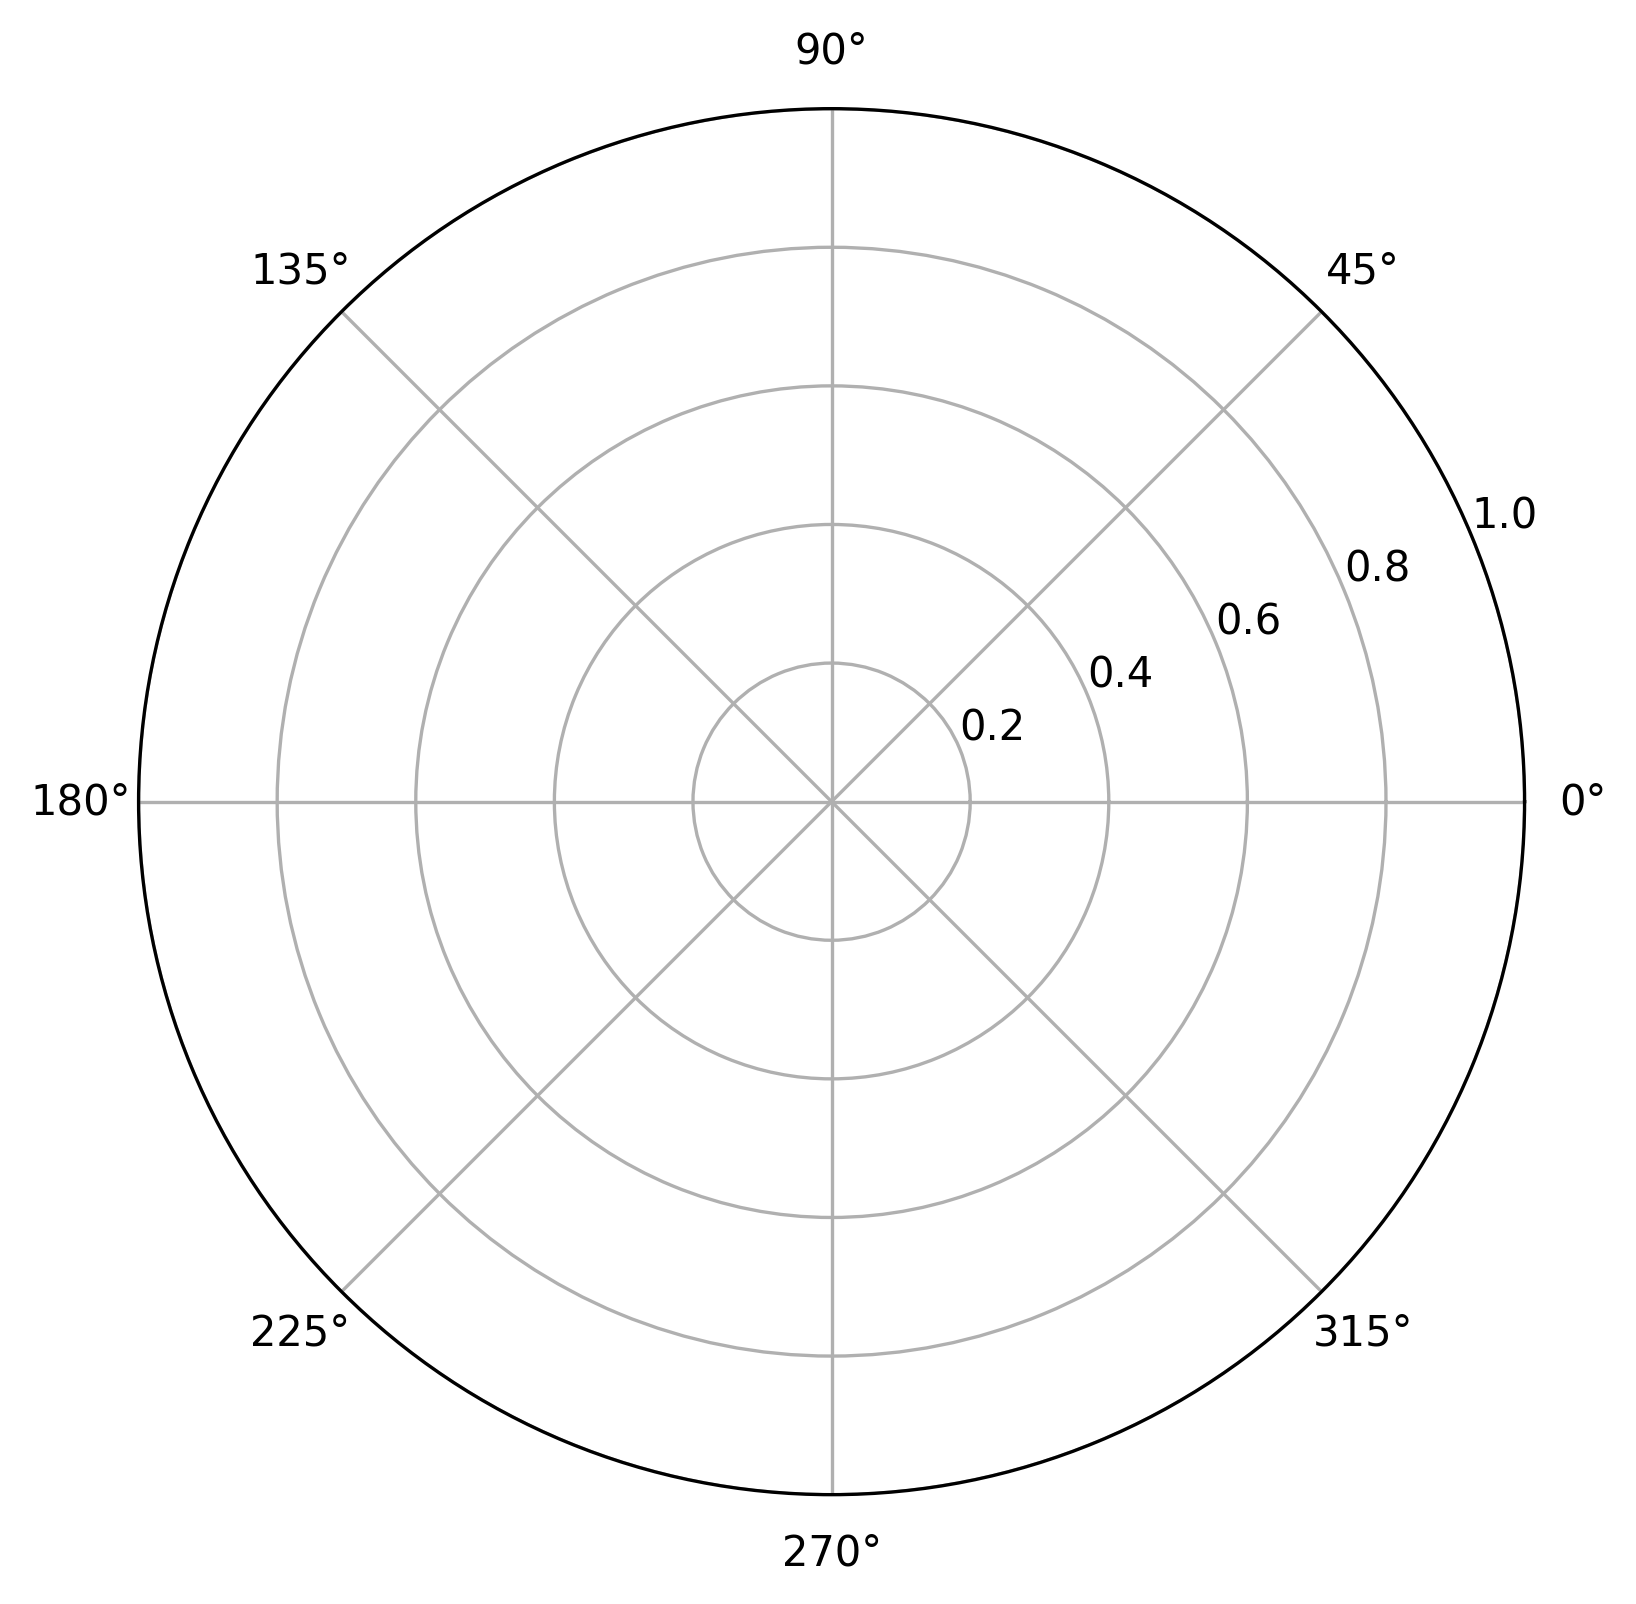

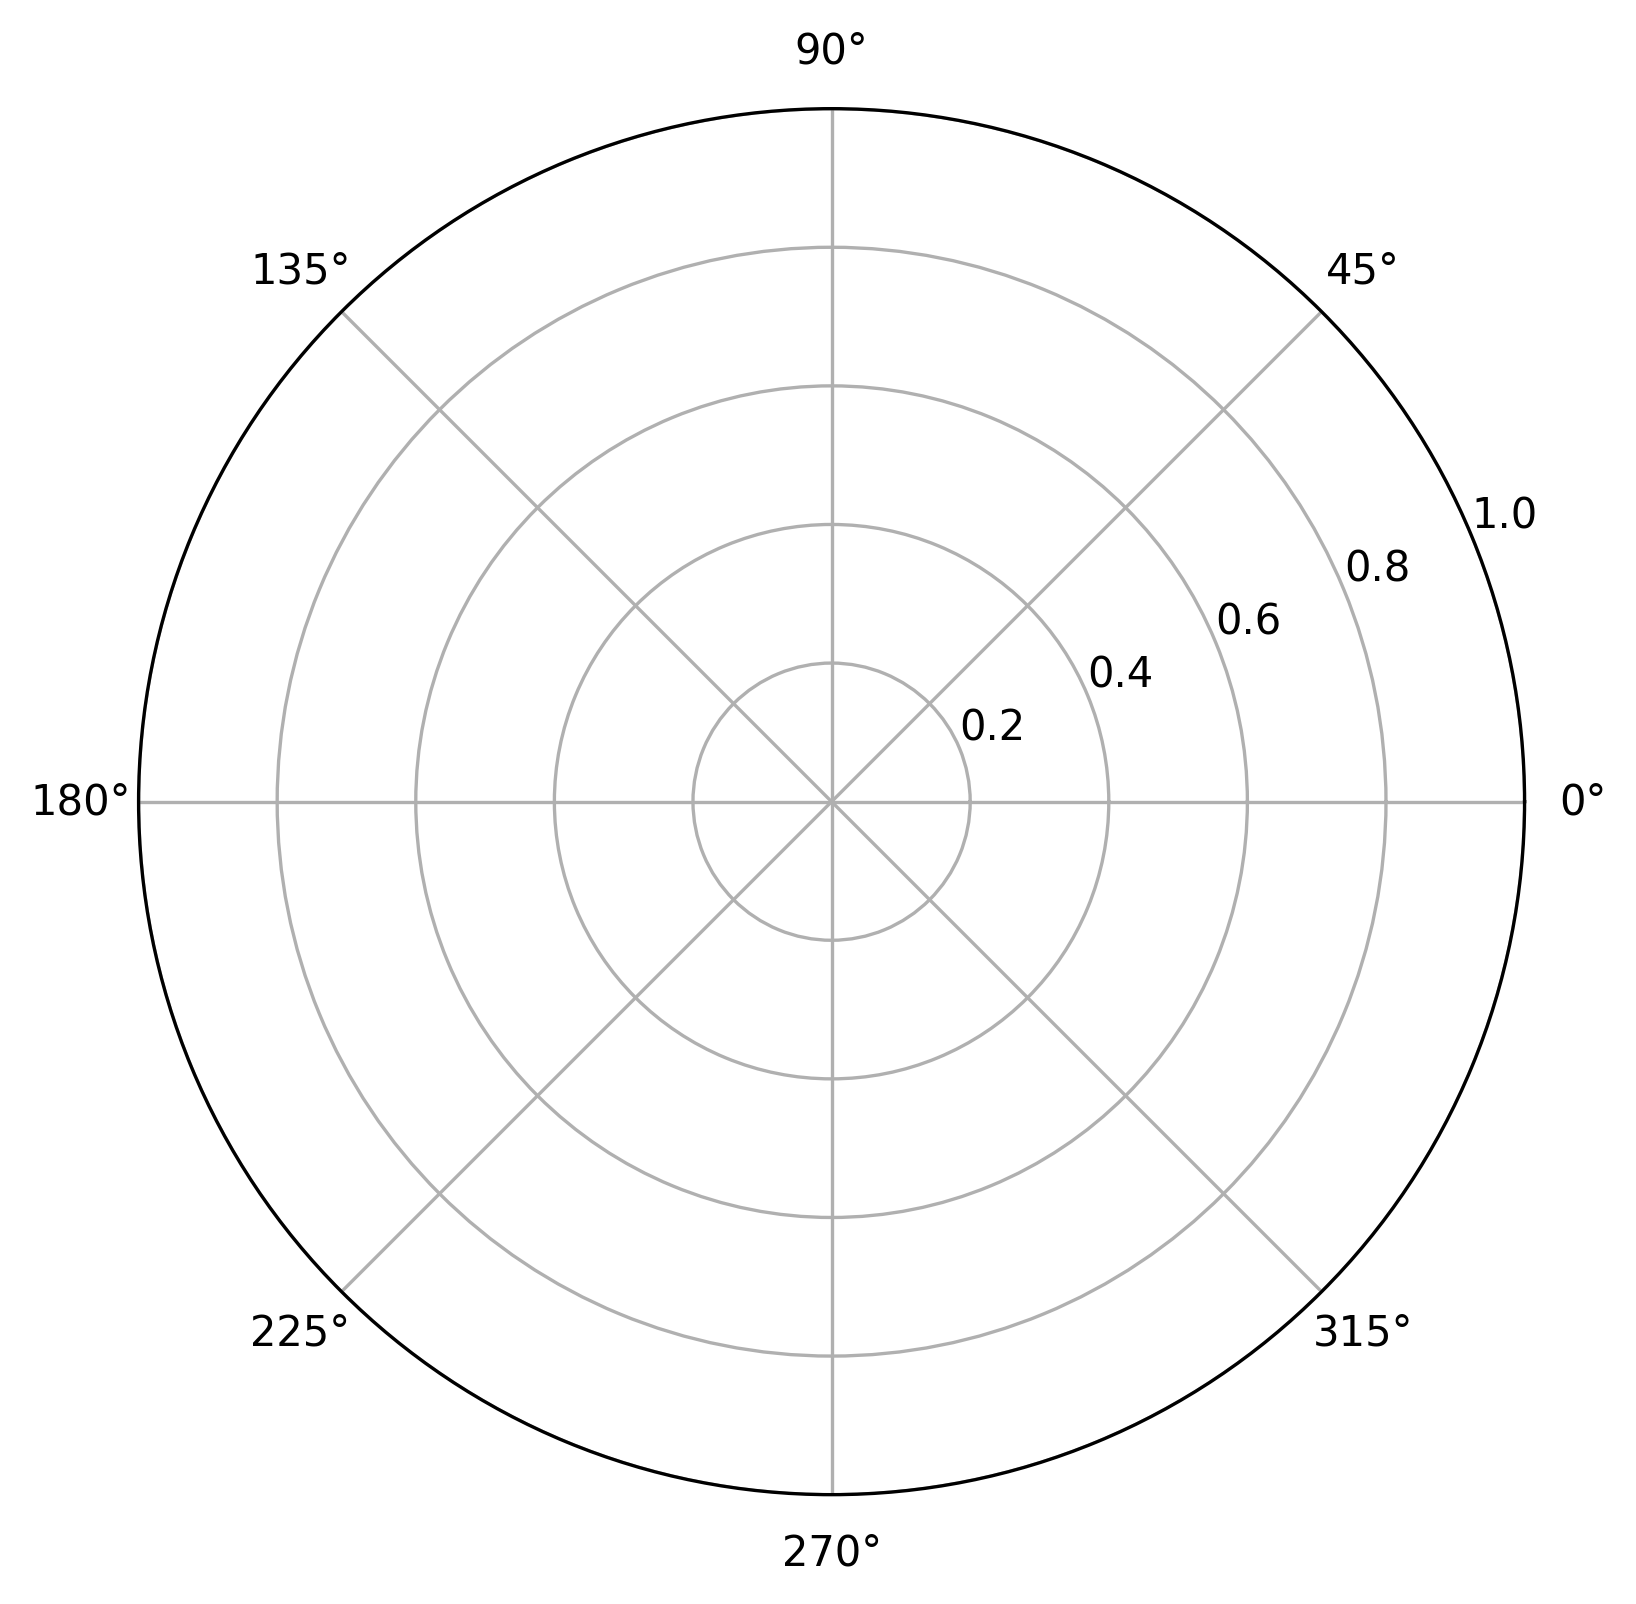

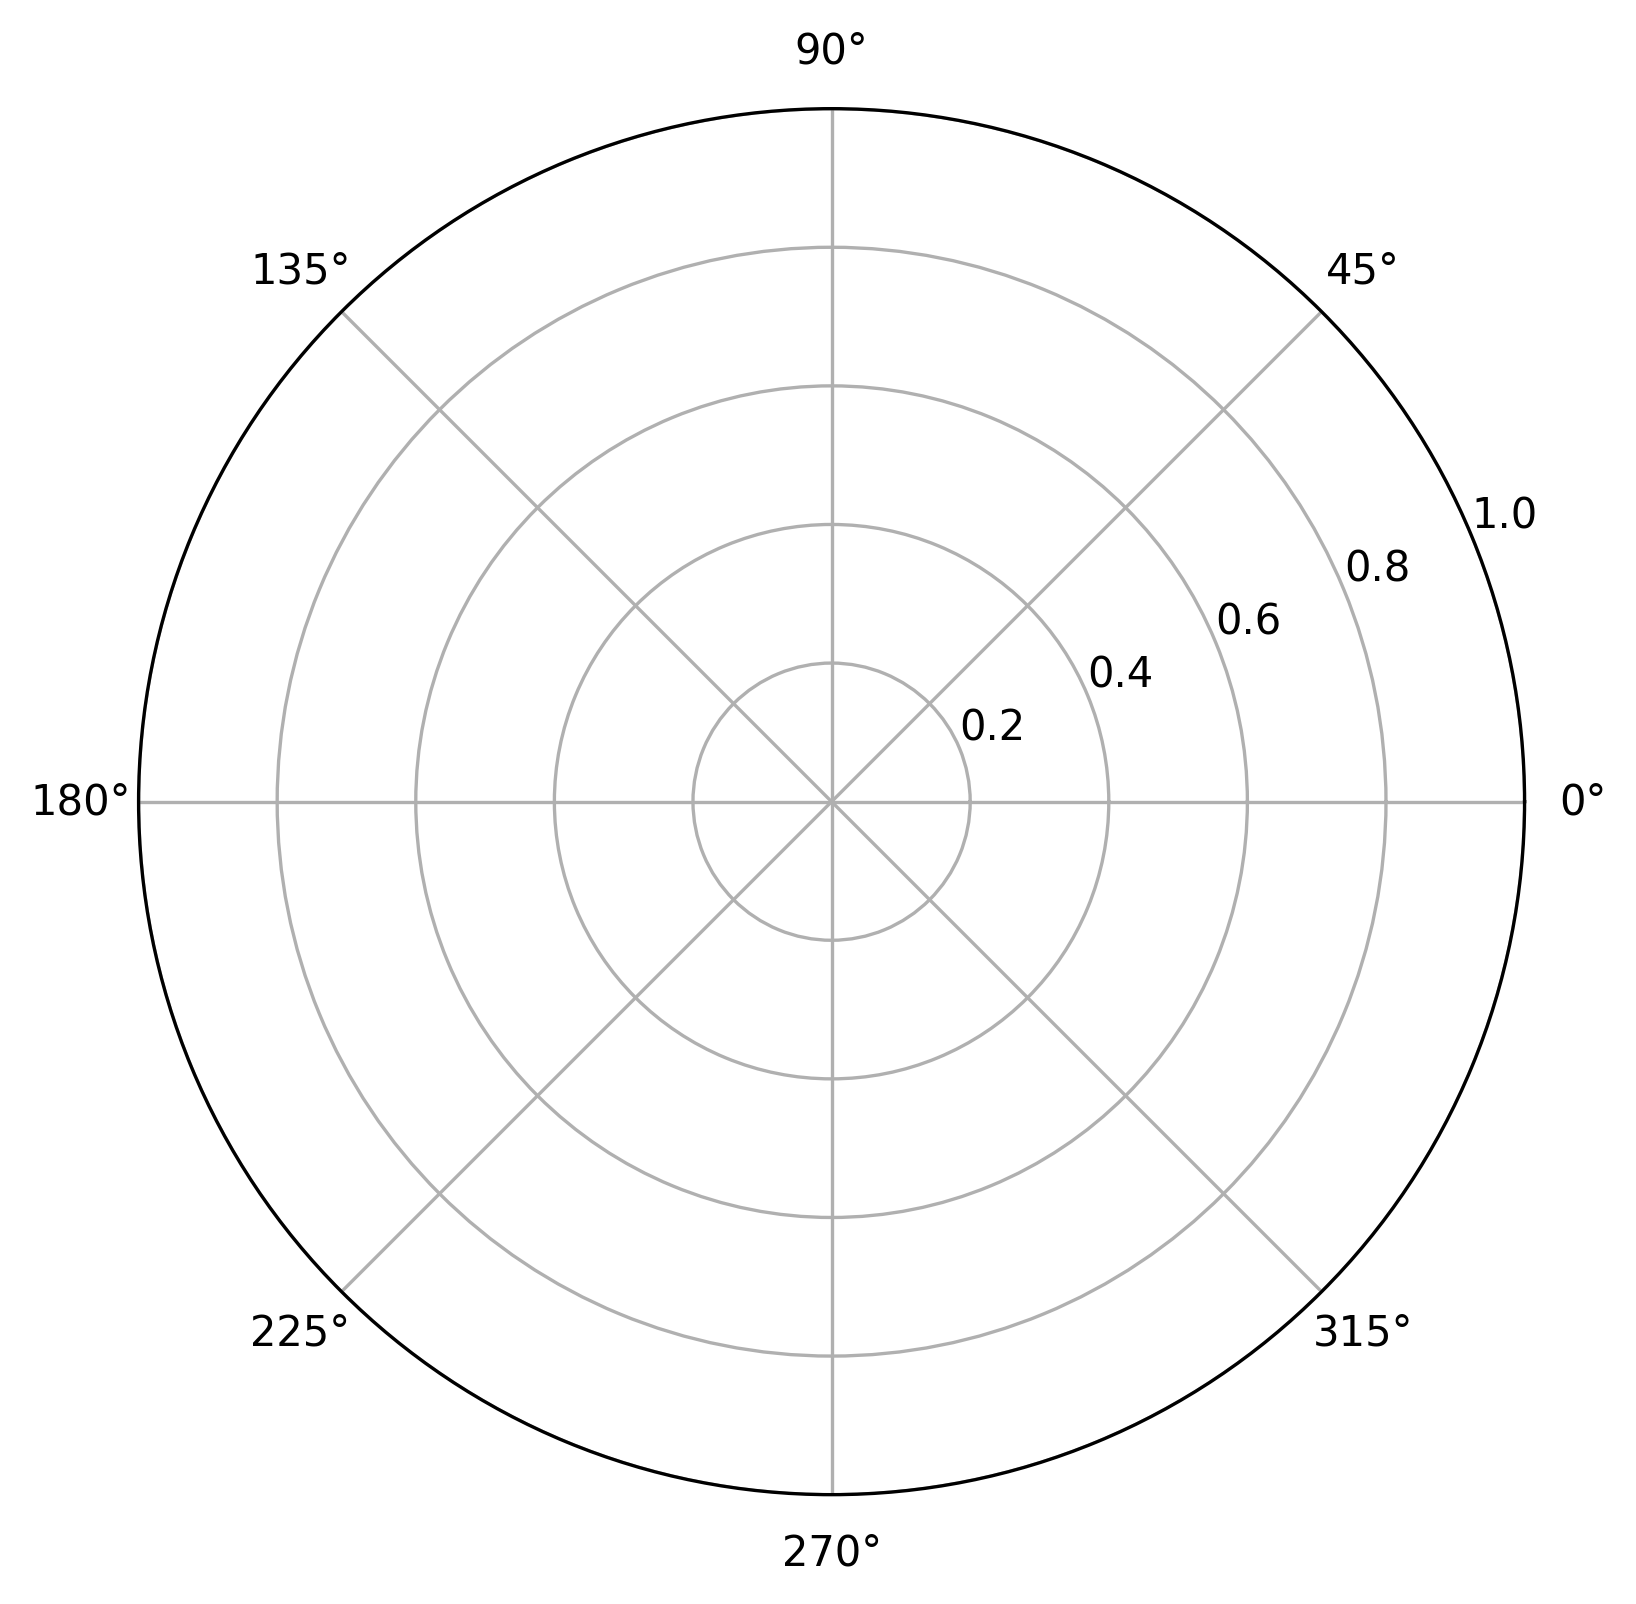

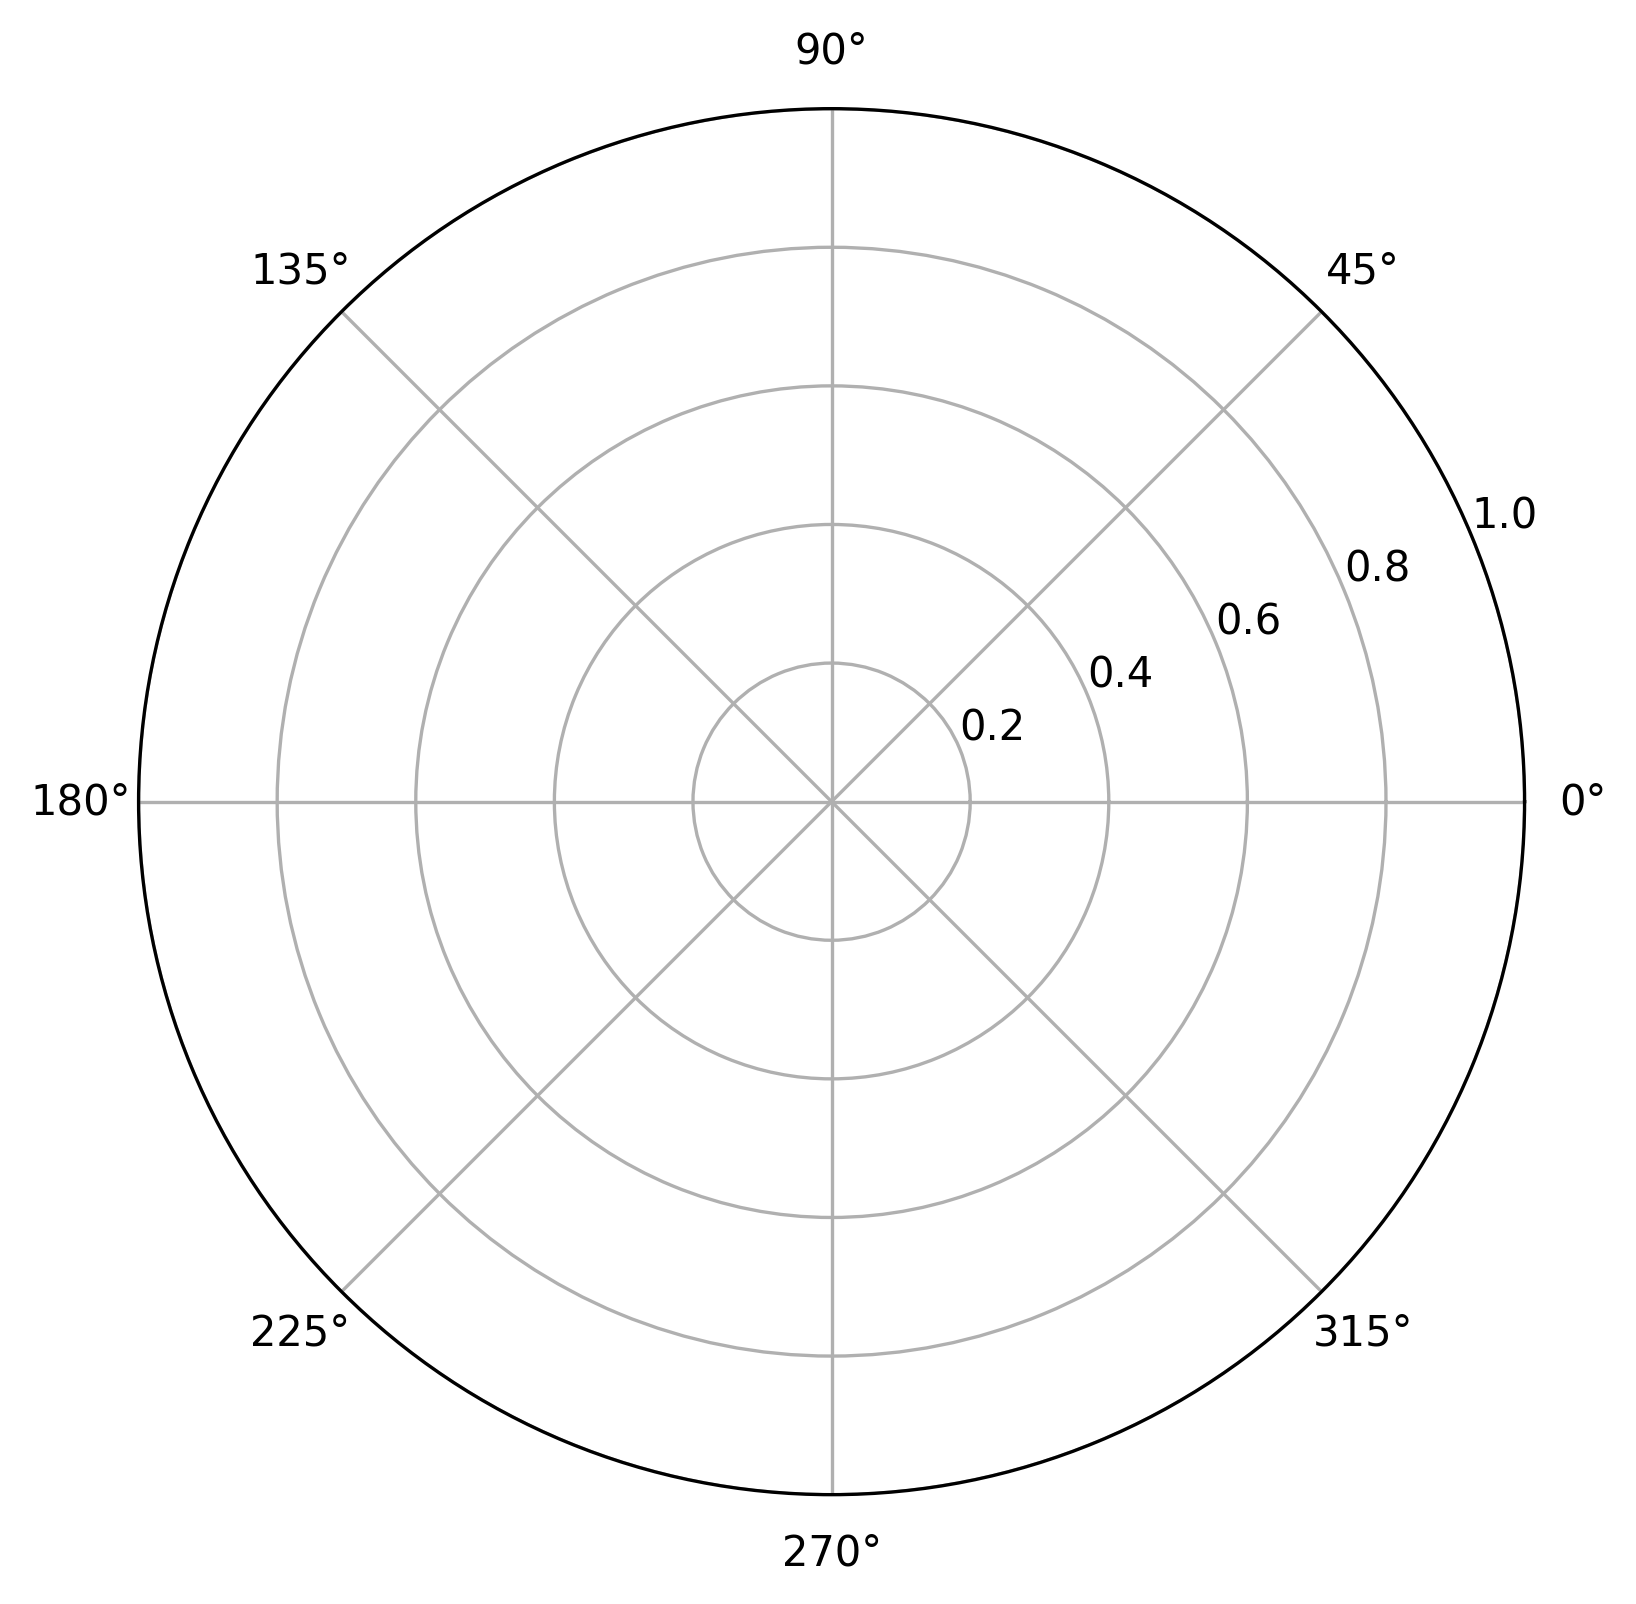

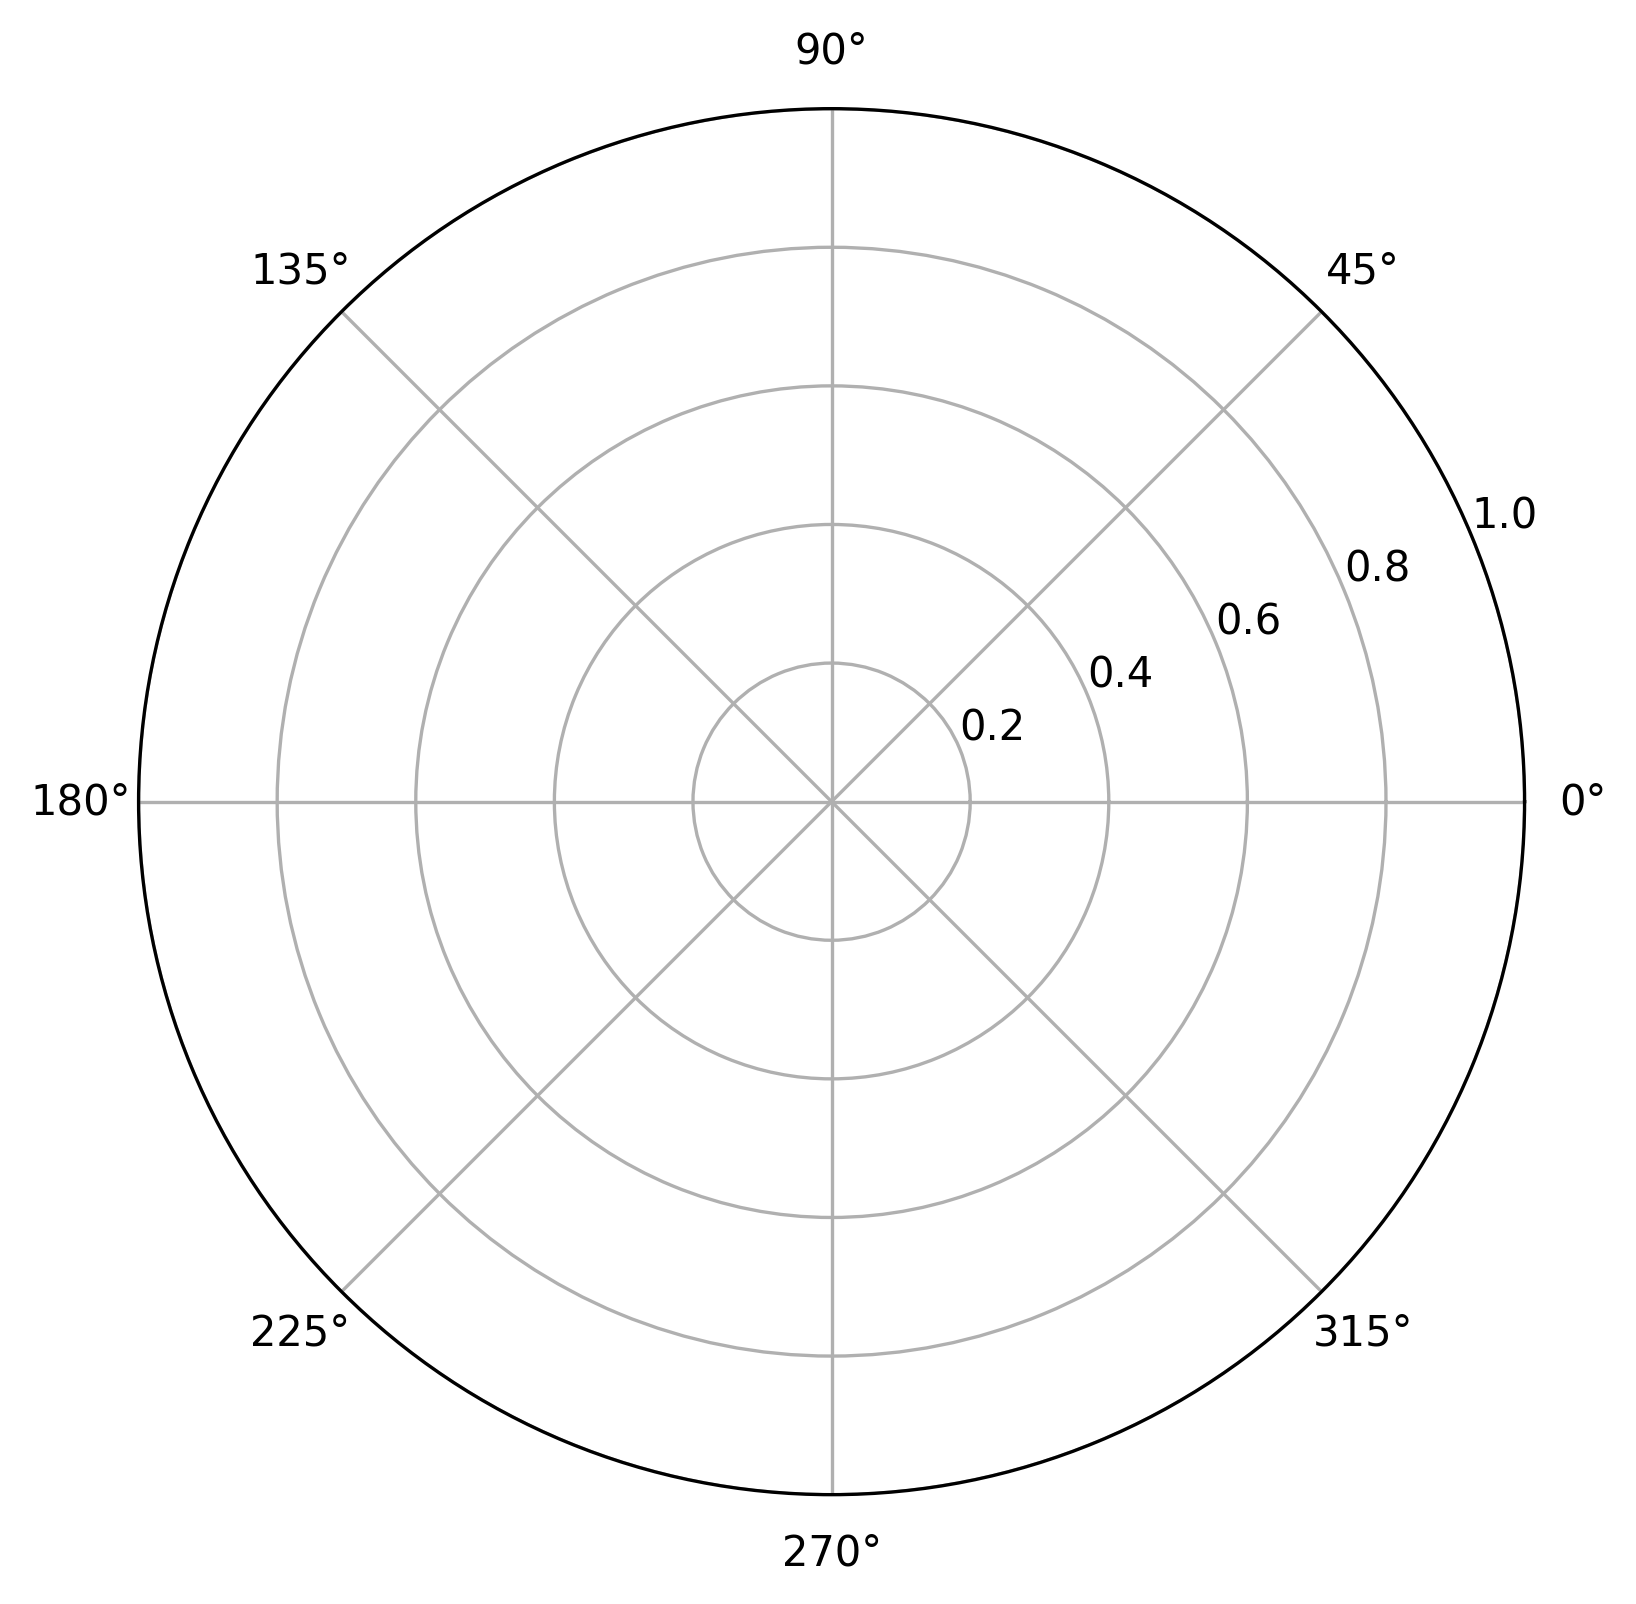

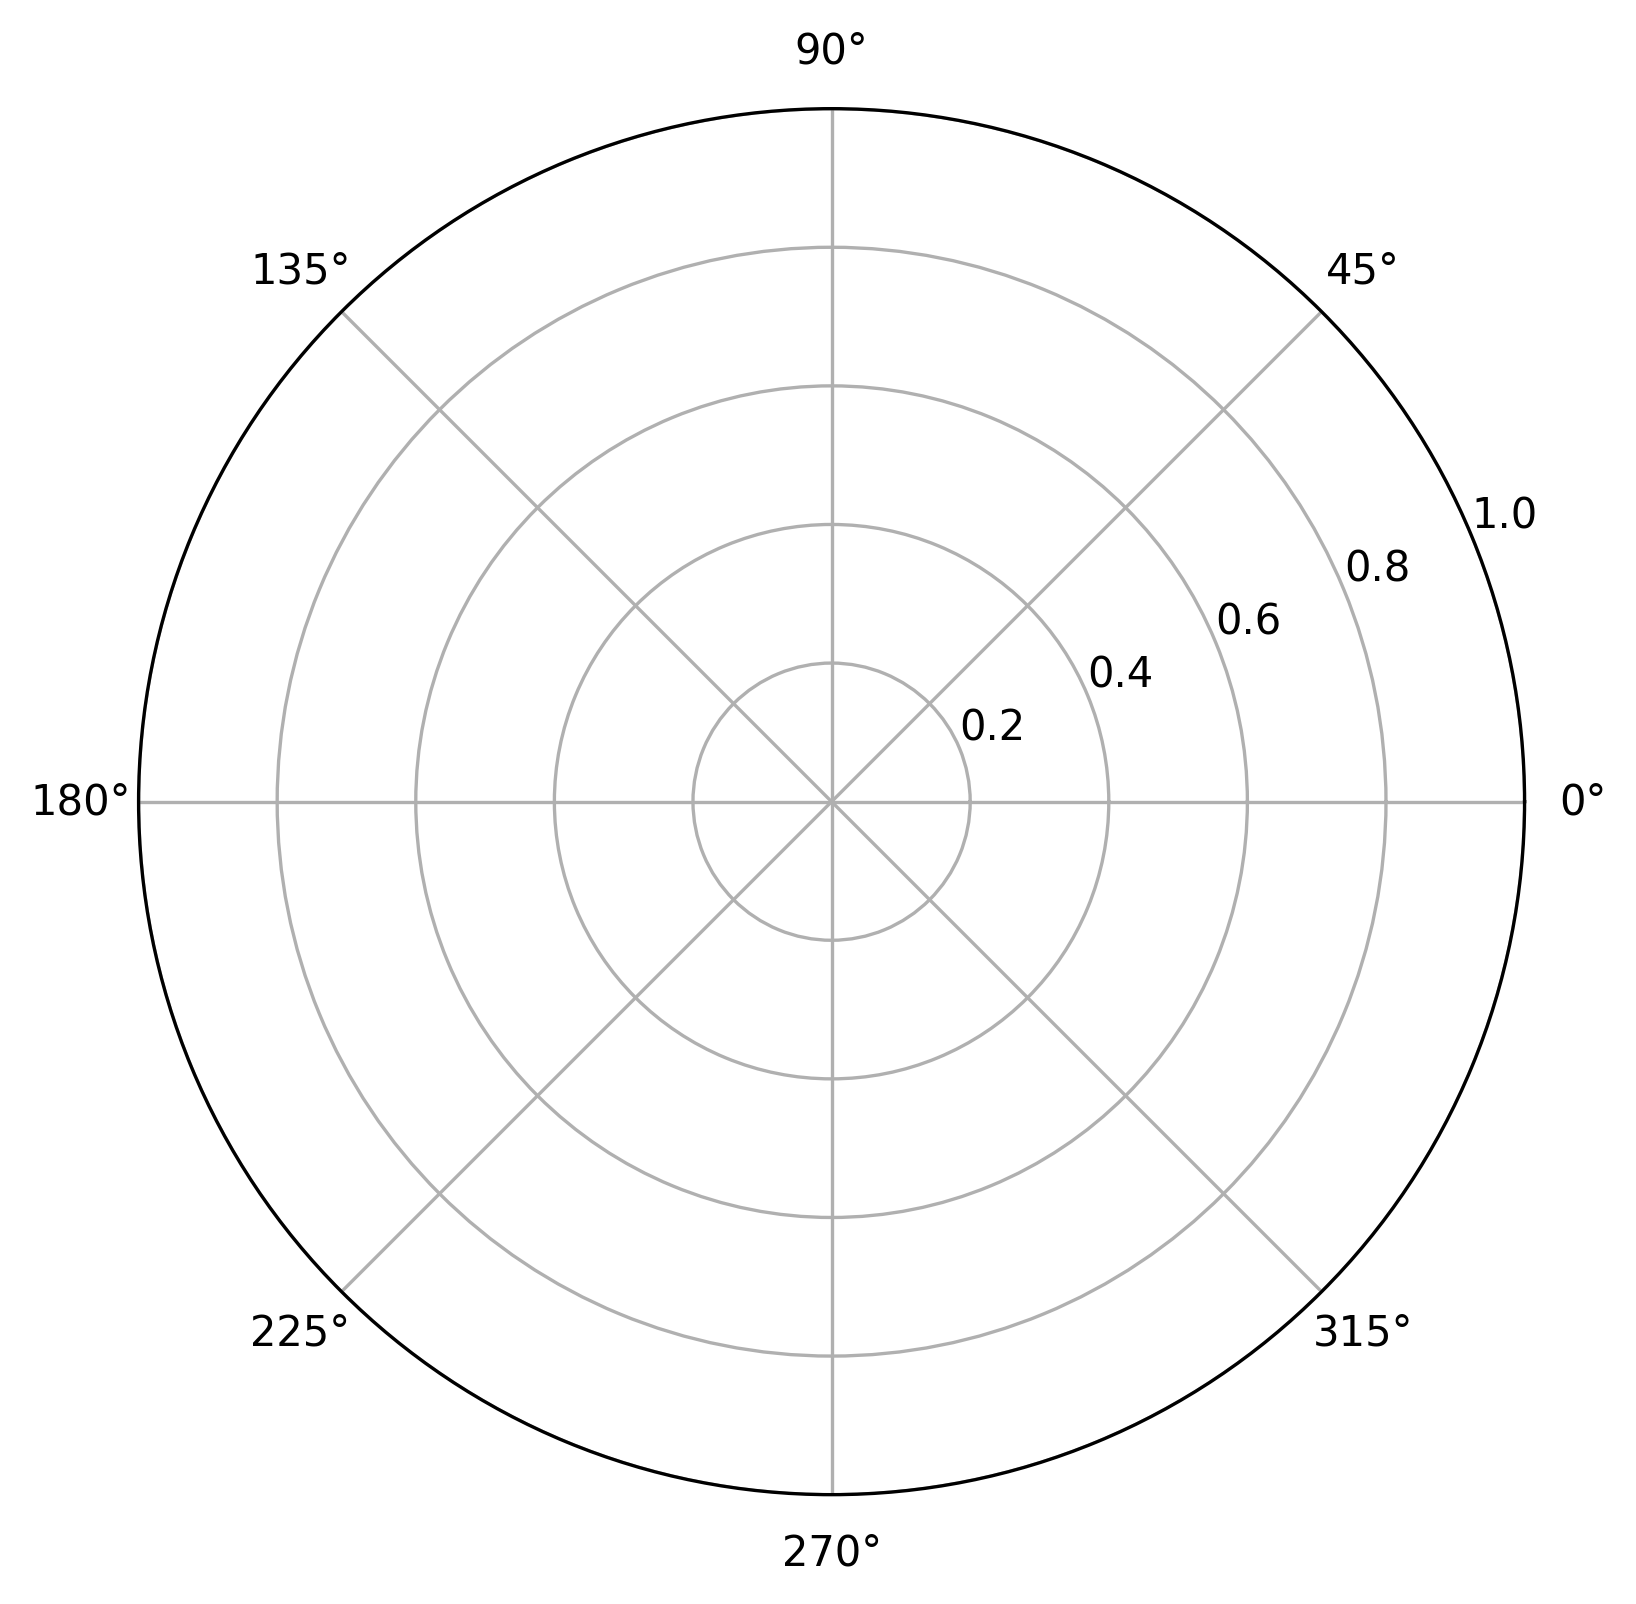

In [ ]:
target_dir = "data"
cluster_csv = "thomson-perceptions-clustering/clustering-perceptions.csv"
input_dir = "thomson-perceptions"
output_dir = "thomson-perceptions-clustering"

datas_path = []
for dirpath, dirnames, filenames in os.walk(os.path.join(target_dir, input_dir)):
    datas_path.extend(filenames)
    break
datas_id = {}
for data_path in datas_path:
    with open(os.path.join(target_dir, input_dir, data_path), 'r') as fp:
        datas_id['.'.join(data_path.split('.')[:-1])] = json.load(fp)
datas_df = pd.DataFrame.from_dict(datas_id, orient='index')

with open(os.path.join(target_dir, cluster_csv), 'r') as fp:
    cluster_df = pd.read_csv(fp, index_col=0)

df = datas_df.join(cluster_df["cluster"], how="inner")
cluster_perceptions = df.groupby(by="cluster").mean()

categories = cluster_perceptions.columns

perception_id = [2,7,8,6,10,1,5,3,4,0,9]
# colours = ["#0078bf", "#3D5588", "#00a95c", "#407060", "#ff48b0", "#d2515e", "#bb8b41", "#ff6c2f", "#765ba7", "#925f52", "#ffe800"]
colours = ["#765ba7", "#925f52", "#0078bf", "#bb8b41", "#ff48b0", "#ff6c2f", "#407060", "#3D5588", "#00a95c", "#ffe800", "#d2515e"]
j = 0
for row in cluster_perceptions.itertuples():
    print(perception_id.index(j), row[0])
    values = row[1:]
    # The radar chart needs to be closed, so append the first value at the end of the values list
    values += values[:1]
    print(values)
    num_categories = len(categories)
    # Create angles for each axis (equally spaced around the circle)
    angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False).tolist()
    angles += angles[:1]
    # Create the radar chart
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True), dpi=300)
    # Set the labels for each category
    ax.set_xticks(angles[:-1])  # Remove the last angle (duplicate of the first)
    ax.set_xticklabels(categories)
    ax.set_ylim(23, 28)
    for i, label in enumerate(ax.get_xticklabels()):
        angle = angles[i]
        if angle > np.pi / 2 and angle < 3 * np.pi / 2:  # Categories on the left half
            label.set_horizontalalignment('right')
        else:  # Categories on the right half
            label.set_horizontalalignment('left')
        # Adjust vertical alignment if necessary
        label.set_verticalalignment('center')
    # Plot the data
    ax.plot(angles, values, linewidth=0, linestyle='solid')

    # Fill the area under the plot
    ax.fill(angles, values, alpha=1, color=colours[j])

    # Show the plot
    with open(os.path.join(target_dir, output_dir, f"perception_cluster_{perception_id.index(j)}_{row[0]}.png"), 'wb') as fp:
        plt.savefig(fp, transparent=True, bbox_inches="tight", pad_inches=0)
    plt.cla()
    # plt.show()
    j += 1    

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

target_dir = "data"
morphology_csv = "thomson-segmented-point-clouds-combined-encoded-clustering/clustering-segmented-point-clouds-combined-encoded.csv"
perception_csv = "thomson-perceptions-clustering/clustering-perceptions.csv"

with open(os.path.join(target_dir, morphology_csv), 'r') as fp:
    morphology_df = pd.read_csv(fp, index_col=0)
with open(os.path.join(target_dir, perception_csv), 'r') as fp:
    perception_df = pd.read_csv(fp, index_col=0)
cluster_df = morphology_df.join(perception_df, how="inner", lsuffix="_morphology", rsuffix="_perception")

cmap = LinearSegmentedColormap.from_list('bright_red', ["#ffffff", "#d2515e"])
fig, ax = plt.subplots(figsize=(9, 9), dpi=300)
ax = sns.heatmap(pd.crosstab(cluster_df["cluster_perception"], cluster_df["cluster_morphology"]),
            annot=True, cmap=cmap, fmt='g')
ax.set(xlabel="Morphology Cluster", ylabel="Perception Cluster")
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
with open(os.path.join(target_dir, f"cluster_histogram.png"), 'wb') as fp:
    plt.savefig(fp, transparent=True, bbox_inches="tight", pad_inches=0)

In [66]:
target_dir = "data/clb"

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

import json
import os
from pathlib import Path

pano = cv2.cvtColor(cv2.imread(os.path.join(target_dir, "pano.jpg"), cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
# pano = cv2.resize(pano, (1024, 512))
height = pano.shape[0]
width = pano.shape[1]
pano_lab = cv2.cvtColor(pano, cv2.COLOR_RGB2LAB).astype(np.double)
porous = cv2.resize(cv2.imread(os.path.join(target_dir, "clb.hpor.pgm"), cv2.IMREAD_GRAYSCALE).astype(np.double), (width, height)) / 255
ground = cv2.resize(cv2.imread(os.path.join(target_dir, "clb.v000.pgm"), cv2.IMREAD_GRAYSCALE).astype(np.double), (width, height)) / 255
vertical = cv2.resize(cv2.imread(os.path.join(target_dir, "clb.v090.pgm"), cv2.IMREAD_GRAYSCALE).astype(np.double), (width, height)) / 255
sky = cv2.resize(cv2.imread(os.path.join(target_dir, "clb.vsky.pgm"), cv2.IMREAD_GRAYSCALE).astype(np.double), (width, height)) / 255

pano_porous = (pano_lab * porous[:, :, np.newaxis]).astype(np.uint8)
pano_ground = (pano_lab * ground[:, :, np.newaxis]).astype(np.uint8)
pano_vertical = (pano_lab * vertical[:, :, np.newaxis]).astype(np.uint8)
pano_sky = (pano_lab * sky[:, :, np.newaxis]).astype(np.uint8)

# histogram3d = np.histogramdd(pano_sky.reshape(height * width, 3), bins=[14, 4, 4], range=[(0, 256), (0, 256), (0, 256)])
# with open(os.path.join(target_dir, "colour histogram sky.json"), 'w') as fp:
#     json.dump(histogram3d[0].tolist(), fp)

# fig, ax = plt.subplots(figsize=(24, 12), dpi=300)
# sns.kdeplot(data=pano_sky[:,:,0].reshape(height * width), color="#000000")
# sns.kdeplot(data=pano_sky[:,:,1].reshape(height * width), color="#ff48b0")
# sns.kdeplot(data=pano_sky[:,:,2].reshape(height * width), color="#ffe800")
# ax.axis("off")
# plt.savefig(os.path.join(target_dir, "colour histogram sky.png"), bbox_inches="tight")
# plt.show()
# plt.close(fig)

map = pano_sky[:,:,0].astype(np.double) / 255

In [67]:
weight = map

# RGB color for the image (e.g., a gradient from white to [255, 72, 176])
rgb_color = np.array([0, 0, 0])

# White color (for weight 0)
white = np.array([255, 255, 255])

output_image_path = os.path.join(target_dir, "pano sky L.png")
os.makedirs(os.path.dirname(output_image_path), exist_ok=True)

def generate_row(row_index, width):
    row = ((1 - weight[row_index][:, np.newaxis]) * white + weight[row_index][:, np.newaxis] * rgb_color).astype(np.uint8)
    return row  # Create a row of the same color

# Create a new image to store the result (this will be updated iteratively)
image = Image.new('RGB', (width, height))

# Process the image in chunks of 100 rows
chunk_size = 3000

# Process and save the image in chunks
for start_row in range(0, height, chunk_size):
    # Calculate the end row for this chunk
    end_row = min(start_row + chunk_size, height)
    
    # Create an empty array for the chunk
    chunk = np.zeros((end_row - start_row, width, 3), dtype=np.uint8)
    
    # Generate each row in the current chunk
    for i in range(start_row, end_row):
        chunk[i - start_row] = generate_row(i, width)
    
    # Convert the chunk to a PIL image and paste it into the full image
    chunk_image = Image.fromarray(chunk)
    image.paste(chunk_image, (0, start_row))
    
    # Save the image after processing this chunk
    image.save(output_image_path)

    # Optionally, clear memory (not strictly necessary in small examples, but useful for large images)
    del chunk_image
    del chunk

    print(f"Saved rows {start_row} to {end_row - 1}")

print(f"Image saved to {output_image_path}")

Saved rows 0 to 2999
Saved rows 3000 to 5999
Saved rows 6000 to 8191
Image saved to data/clb/pano sky L.png


In [56]:
target_dir = "data/clb"

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

import json
import os
from pathlib import Path

textonmap = cv2.cvtColor(cv2.imread(os.path.join(target_dir, "textonmap.png"), cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
height = textonmap.shape[0]
width = textonmap.shape[1]
porous = cv2.resize(cv2.imread(os.path.join(target_dir, "clb.hpor.pgm"), cv2.IMREAD_GRAYSCALE).astype(np.double), (width, height)) / 255
ground = cv2.resize(cv2.imread(os.path.join(target_dir, "clb.v000.pgm"), cv2.IMREAD_GRAYSCALE).astype(np.double), (width, height)) / 255
vertical = cv2.resize(cv2.imread(os.path.join(target_dir, "clb.v090.pgm"), cv2.IMREAD_GRAYSCALE).astype(np.double), (width, height)) / 255
sky = cv2.resize(cv2.imread(os.path.join(target_dir, "clb.vsky.pgm"), cv2.IMREAD_GRAYSCALE).astype(np.double), (width, height)) / 255

textonmap_porous = (textonmap * porous[:, :, np.newaxis]).astype(np.uint8)
textonmap_ground = (textonmap * ground[:, :, np.newaxis]).astype(np.uint8)
textonmap_vertical = (textonmap * vertical[:, :, np.newaxis]).astype(np.uint8)
textonmap_sky = (textonmap * sky[:, :, np.newaxis]).astype(np.uint8)

# histogram3d = np.histogramdd(textonmap_sky.reshape(height * width, 3), bins=[8, 8, 8], range=[(0, 256), (0, 256), (0, 256)])
# with open(os.path.join(target_dir, "textonmap histogram sky.json"), 'w') as fp:
#     json.dump(histogram3d[0].tolist(), fp)

# fig, ax = plt.subplots(figsize=(24, 12), dpi=300)
# sns.kdeplot(data=textonmap_sky[:,:,0].reshape(height * width), color="#ff665e")
# sns.kdeplot(data=textonmap_sky[:,:,1].reshape(height * width), color="#00a95c")
# sns.kdeplot(data=textonmap_sky[:,:,2].reshape(height * width), color="#0078bf")
# ax.axis("off")
# plt.savefig(os.path.join(target_dir, "textonmap histogram sky.png"), bbox_inches="tight")
# plt.show()
# plt.close(fig)

map = textonmap_sky[:,:,2].astype(np.double) / 255

In [1]:
target_dir = "data/jln_sembilang"

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

import json
import os
from pathlib import Path

with open(os.path.join(target_dir, "semantic.json"), 'r') as fp:
    semantic = json.load(fp)
semantic_colours = {
    0: (0, 0, 0),
    1: (136, 137, 138),
    2: (61, 85, 136),
    3: (146, 95, 82),
    4: (210, 81, 94),
    5: (145, 78, 114),
    6: (241, 80, 96),
    7: (255, 232, 0),
    8: (0, 169, 92),
    9: (64, 112, 96),
    10: (0, 120, 191),
    11: (255, 72, 176),
    12: (210, 81, 94),
    13: (255, 108, 47),
    14: (0, 131, 138),
    15: (118, 91, 167),
    16: (187, 139, 65),
    17: (210, 81, 94),
    18: (210, 81, 94)
}
semantic_image = np.zeros((*np.array(semantic).shape, 3), dtype=np.uint8)
for i in range(len(semantic)):
    for j in range(len(semantic[0])):
        colour = semantic_colours[semantic[i][j]]
        semantic_image[i, j] = colour
Image.fromarray(semantic_image).save(os.path.join(target_dir, "semantic.png"))

In [2]:
target_dir = "data/jln_sembilang"

import cv2
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

import json
import os
from pathlib import Path

with open(os.path.join(target_dir, "depth.json"), 'r') as fp:
    depth = json.load(fp)
print(np.array(depth).max())
cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#000000", "#ffffff"])
fig, ax = plt.subplots()
cax = plt.imshow(depth, cmap=cmap)
ax.axis("off")
# cbar = plt.colorbar(cax, ax=ax, orientation="horizontal", fraction=0.05, pad=-0.1)
# cbar.outline.set_edgecolor("white")
# for label in cbar.ax.get_xticklabels():
#     label.set_color("white")
#     label.set_path_effects([path_effects.withStroke(linewidth=1, foreground='black')])
# cbar.ax.tick_params(labelsize=8)
plt.savefig(os.path.join(target_dir, "depthmap.png"), bbox_inches="tight")
plt.close(fig)

19.968460083007812


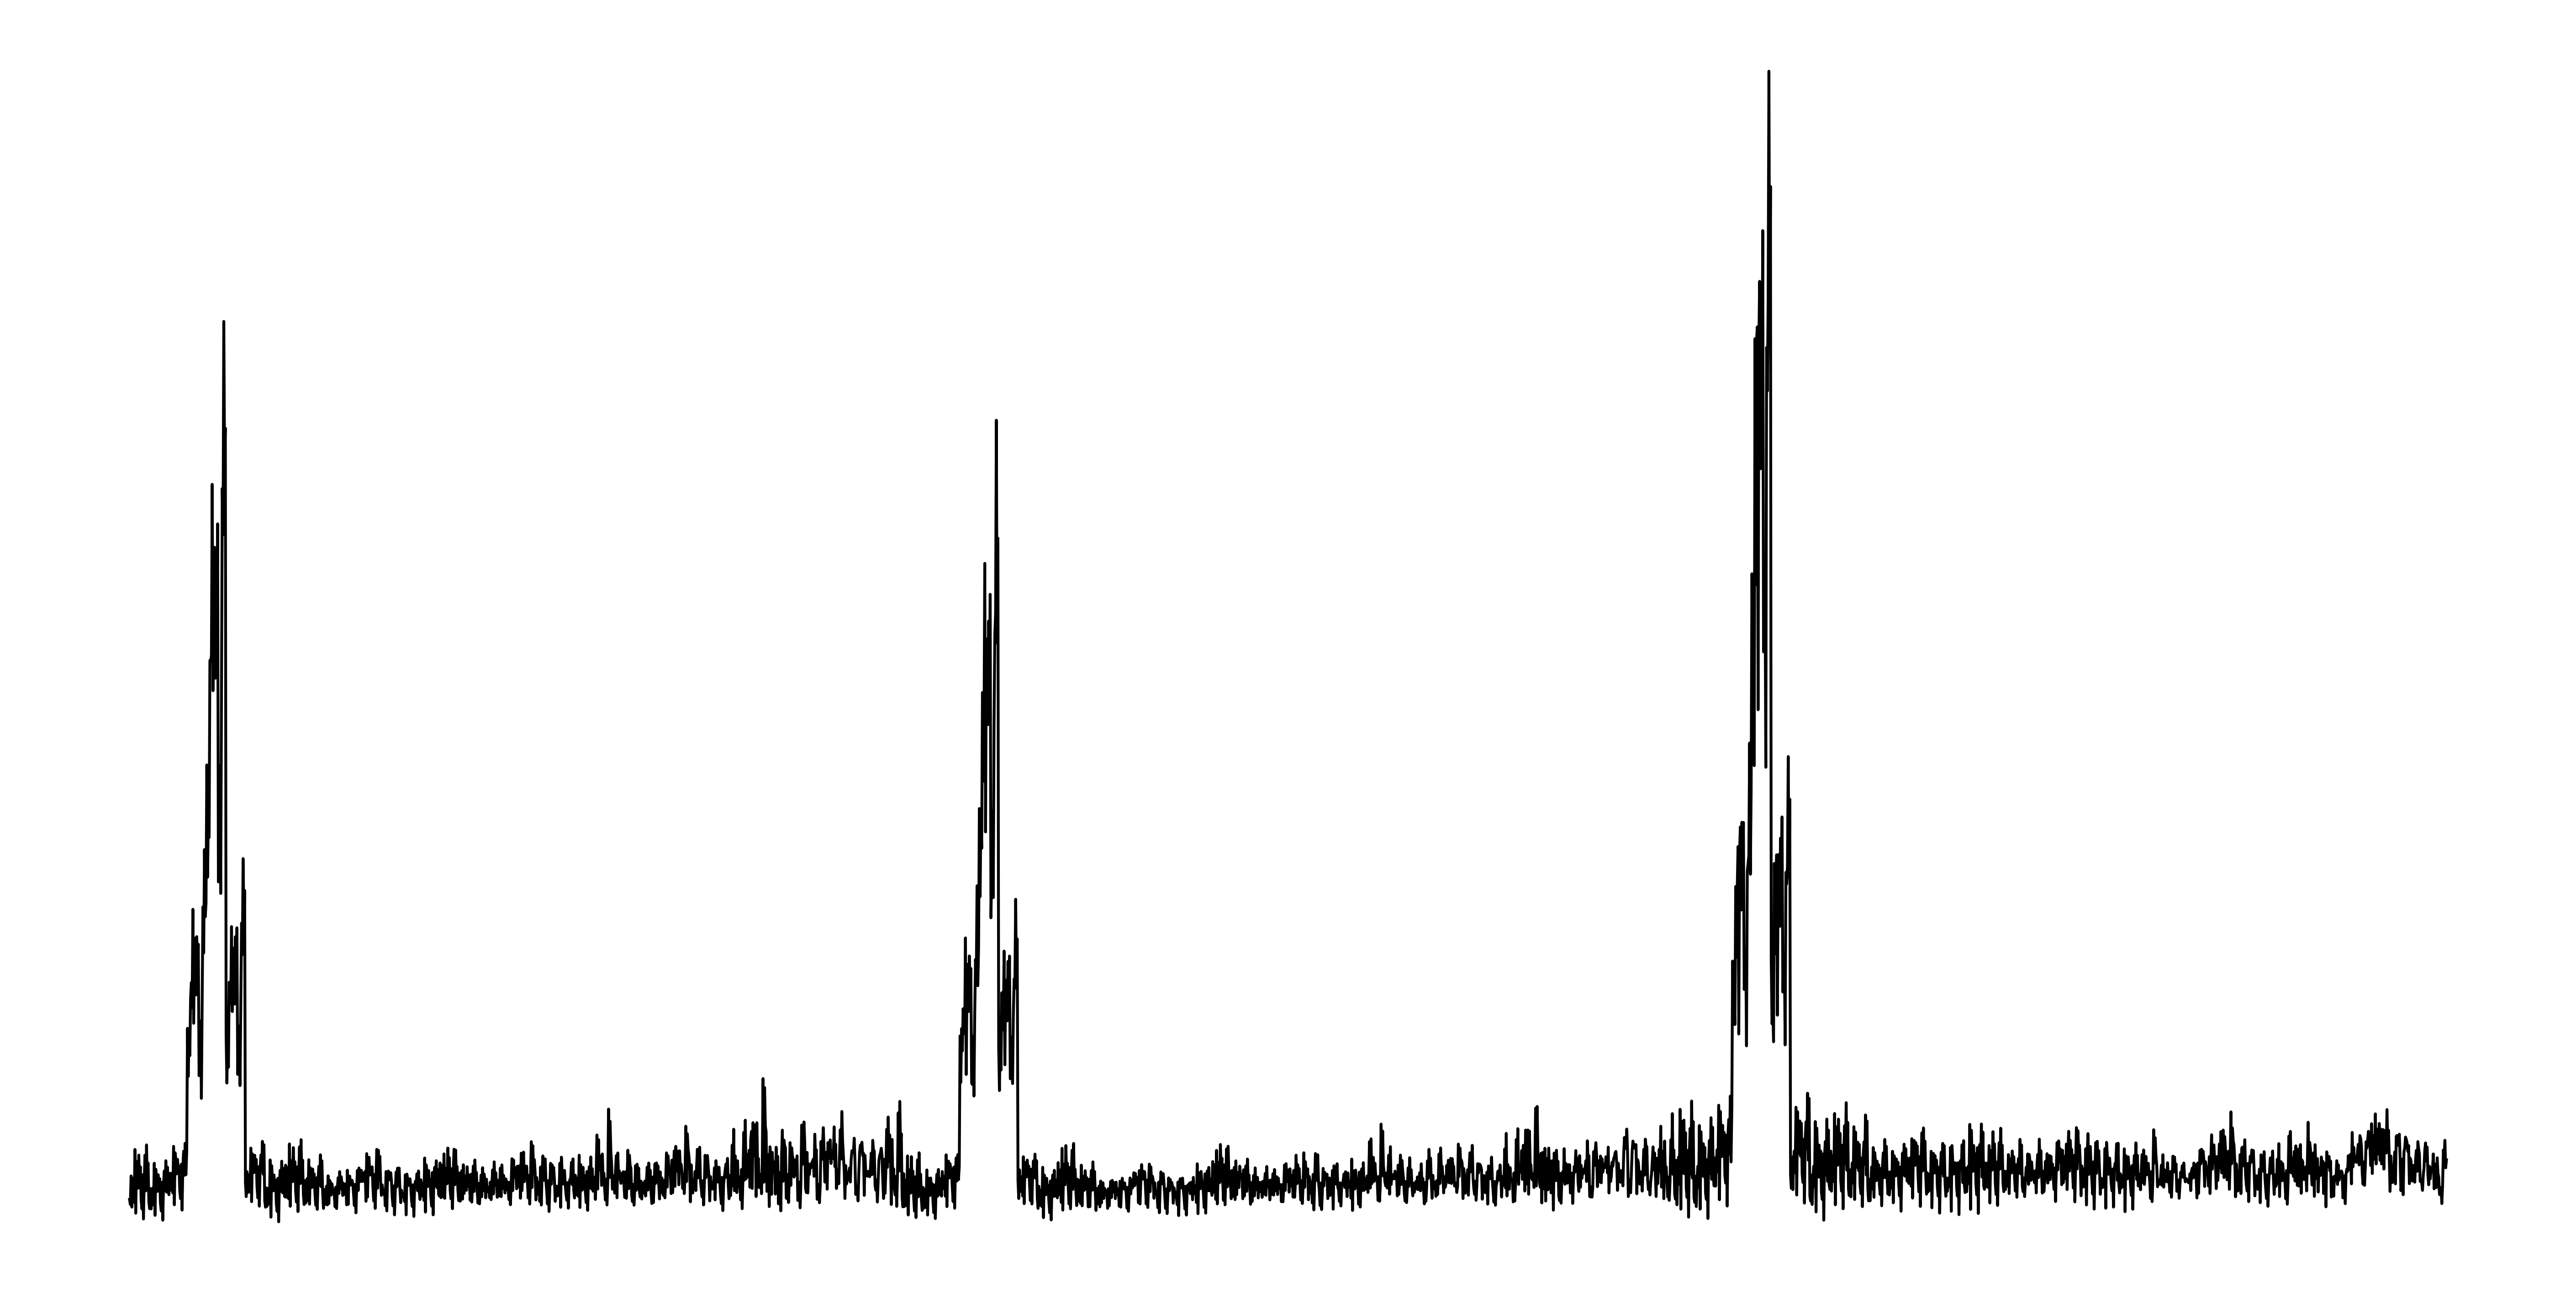

In [ ]:
target_dir = "data/clb"

import matplotlib.pyplot as plt
import seaborn as sns

import csv
import os

gist = []
with open(os.path.join(target_dir, "gist.csv"), 'r') as fp:
    reader = csv.reader(fp)
    for row in reader:
        gist.append(float(row[0]))

fig, ax = plt.subplots(figsize=(24, 12), dpi=300)
sns.lineplot(gist, color="#000000")
ax.axis("off")
plt.savefig(os.path.join(target_dir, "gist.png"), bbox_inches="tight")
plt.show()
plt.close(fig)